# DVL Navigation and State Estimation

1. [Import Libraries](#import-libraries)
    1. [Glider Flight Computer Data](#import-glider-flight-computer)
    1. [Bathymetry Data](#import-bathymetry)
    1. [DVL Data](#import-dvl-data)
    1. [Select Time Series](#import-select-time-series)
1. [Load and Parse Data](#load-and-parse-data)
1. [Compute Water Column Currents](#compute-water-column-currents)
1. [Compute DVL-Odometry](#compute-dvl-odometry)
1. [Multi-Factor Terrain Aided Navigation](#multi-factor-terrain-aided-navigation)
1. [Sandbox](#sandbox)
1. [Unit Testing](#unit-testing)


---
<a id='import-libraries'></a>
## Import Libraries

In [2]:
import datetime
import earthpy as et
import earthpy.plot as ep
import importlib
import numpy as np
import os
import pandas as pd
import rasterio as rio
import scipy
import scipy.signal
import seaborn as sns 
import struct
import sys
import utm
import unittest
from PIL import Image
from matplotlib import pyplot as plt 
from os import listdir
from os.path import isfile, join

# add parent directory to the path for importing modules 
sys.path.insert(1, os.path.join(sys.path[0], '..'))
sys.path.append(os.path.join(sys.path[0], '../data'))

# objects for parsing raw DVL data 
import PathfinderDVL
import PathfinderEnsemble
import PathfinderTimeSeries

# objects for estimating ocean current velocities
import VelocityShearPropagation

# objects for controlling thruster to minimize transport cost 
import AdaptiveVelocityController

# objects for parsing flight and science computer log files
import SlocumFlightController
import SlocumScienceController
import dvl_plotter
import BathymetryMap
import MultiFactorTAN

# data for parsing seafloor bathymetry
import bathy_meta_data
sns.set()

def reload_modules():
    importlib.reload(PathfinderDVL)
    importlib.reload(PathfinderEnsemble)
    importlib.reload(PathfinderTimeSeries)
    importlib.reload(VelocityShearPropagation)
    importlib.reload(AdaptiveVelocityController)
    importlib.reload(SlocumFlightController)
    importlib.reload(SlocumScienceController)
    importlib.reload(dvl_plotter)
    importlib.reload(bathy_meta_data)
    importlib.reload(BathymetryMap)
    importlib.reload(MultiFactorTAN)
print('Done!')

Done!


---
<a id='load-and-parse-data'></a>
## Load and/or Parse Data
<a id='import-glider-flight-computer'></a>
### A. Glider Flight Computer Data

In [3]:
reload_modules()
directory = "/Users/zduguid/Dropbox (MIT)/MIT-WHOI/Kolumbo cruise 2019/zduguid/dbd-parsed/sentinel_2019-Nov/"
ts_flight_kolumbo_all = SlocumFlightController.SlocumFlightController.from_directory(directory, save=False, verbose=False)

>> Parsing folder of ASC Files
>> Finished Parsing!


In [ ]:
def get_utm_coords_from_glider_lat_lon(m_lat, m_lon):
    SECS_IN_MIN = 60
    MIN_OFFSET = 100
    lat_min  = m_lat % MIN_OFFSET 
    lon_min  = m_lon % MIN_OFFSET 
    lat_dec  = (m_lat - lat_min)/MIN_OFFSET + lat_min/SECS_IN_MIN
    lon_dec  = (m_lon - lon_min)/MIN_OFFSET + lon_min/SECS_IN_MIN
    utm_pos  = utm.from_latlon(lat_dec, lon_dec)
    easting  = round(utm_pos[0],2)
    northing = round(utm_pos[1],2)
    zone     = utm_pos[2]
    return(easting, northing, zone)

---
<a id='import-bathymetry'></a>
### B. Seafloor Bathymetry Data

In [4]:
reload_modules()
# meta_dict = bathy_meta_data.BathyData["Kolumbo_full"]
meta_dict = bathy_meta_data.BathyData["Kolumbo"]
bathy     = BathymetryMap.BathymetryMap(meta_dict=meta_dict)
bathy.parse_bathy_file()

In [874]:
bathy_df = pd.read_csv('/Users/zduguid/Desktop/dat/Kolumbo-10m-sub.csv')

---
<a id='import-dvl-data'></a>
### C. DVL data 

In [6]:
reload_modules()
glider = "sentinel"
filepath = "/Users/zduguid/Dropbox (MIT)/MIT-WHOI/Kolumbo cruise 2019/zduguid/pd0-raw/%s/" % (glider)

#################################################
# File ID Number ################################
#################################################
filename2  = "sk211652.pd0" # DIVE 2
filename3  = "01820002.pd0" # DIVE 3
filename4  = "sk220034.pd0" # DIVE 4
filename5  = "01820008.pd0" # DIVE 5
filename7  = "01820013.pd0" # DIVE 7
filename9  = "sk222256.pd0" # DIVE 9
filename12 = "sk230350.pd0" # DIVE 12
filename14 = "sk261222.pd0" # DIVE 14

#################################################
# Parse Selected File IDs #######################
#################################################
ts2  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename2,  save=False)
ts3  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename3,  save=False)
ts4  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename4,  save=False)
ts5  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename5,  save=False)
ts7  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename7,  save=False)
ts9  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename9,  save=False)
ts12 = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename12, save=False)
ts14 = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename14, save=False)

#################################################
# Frontiers (and Thesis) Naming Convention ######
#################################################
tsa  = ts14
tsb  = ts12 # (no bottom)
tsc  = ts2  # (no bottom)
tsd  = ts3 
tse  = ts4
tsf  = ts5
tsg  = ts7 # (not included in Frontiers)
# tsh  = ts9 # (not included in Frontiers)

#################################################
# JFR Naming Convention #########################
#################################################
# tsa  = ts14
# tsb  = ts5
# tsc  = ts4
# tsd  = ts3
# tse  = ts7

________________________________________
- Parsing DVL File ---------------------
    input file: sk211652.pd0
    # ensembles:    200
    # ensembles:    400
    # ensembles:    600
    # ensembles:    800
    # ensembles:   1000
    # ensembles:   1200
    # ensembles:   1400
    # ensembles:   1600
    # ensembles:   1800
    # ensembles:   2000
    # ensembles:   2200
    # ensembles:   2400
    # ensembles:   2600
    # ensembles:   2800
    # ensembles:   3000
    # ensembles:   3200
    # ensembles:   3400
- Parsing Complete ---------------------
    # ensembles:   3442
    parsing time:  10.101726
- Sensor Configuration -----------------
    600kHz System
    Convex Beam Pattern
    Sensor Config #1
    Attached
    Down Facing
    30E Beam Angle
    4 Beam Janus
- Coordinate Transformation ------------
    Bin Mapping Used
    3-Beam Soln Used
    Tilts Used
    Earth Coords
________________________________________
- Parsing DVL File ---------------------
    input file: 01820

---
<a id='import-select-time-series'></a>
### D. Select Time Series 

In [1056]:
ts = tsf

---
<a id='compute-water-column-currents'></a>
## Compute Water Column Currents 

In [1057]:
reload_modules()

# tuning parameters for working with DVL data 
pitch_bias           =  8    # [deg]   mounting pitch bias for the sonar
start_filter         =  2    # [bin #] avoid using the first number of bins
end_filter           =  2    # [bin #] avoid using the last number of bins 
voc_mag_filter       =  1.0  # [m/s]   filter out ocean current 
voc_delta_mag_filter =  0.5  # [m/s]   filter out deltas between layers
near_surface_filter  = 10    # [m]     ignore Vtw when near surface 

# constants
DEG_TO_RAD = np.pi/180

# determine DVL parameters 
bin_len      = ts.df.depth_bin_length[0]
bin0_dist    = ts.df.bin0_distance[0]
bin_len      = np.cos(pitch_bias*DEG_TO_RAD)*bin_len
bin0_dist    = np.cos(pitch_bias*DEG_TO_RAD)*bin0_dist
max_range    = 80
max_depth    = int(np.max(ts.df.depth)+80)
x_beam       = 0
y_beam       = 1

# intialize water column
water_column = VelocityShearPropagation.WaterColumn(
    bin_len=bin_len, 
    bin0_dist=bin0_dist,
    max_depth=max_depth,
    start_filter=start_filter,
    end_filter=end_filter,
    voc_mag_filter=voc_mag_filter,
    voc_delta_mag_filter=voc_delta_mag_filter,
)

# iterate over the DVL ensembles 
for t in range(len(ts.df)):

    # only use Vtw from pressure sensor when submerged 
    depth = ts.df.depth[t]
    pitch = ts.df.pitch[t]
    roll  = ts.df.roll[t]
    if depth > near_surface_filter:
        vtw_u = ts.df.rel_vel_pressure_u[t]
        vtw_v = ts.df.rel_vel_pressure_v[t]
        
    # otherwise use the DVL to estimate the Vtw at the surface
    else:
        vtw_u = ts.df.rel_vel_dvl_u[t]
        vtw_v = ts.df.rel_vel_dvl_v[t]
    
    # extract Voc reference from bottom track velocity when available
    if not np.isnan(ts.df.abs_vel_btm_u[t]):
        vog_u = ts.df.abs_vel_btm_u[t]
        vog_v = ts.df.abs_vel_btm_v[t]
        voc_u = vog_u - vtw_u
        voc_v = vog_v - vtw_v
        voc_ref = VelocityShearPropagation.OceanCurrent(voc_u, voc_v, 0)
    else:
        voc_ref = VelocityShearPropagation.OceanCurrent()
        
    # add shear nodes for each DVL depth bin that meet the filter criteria
    num_good_vel_bins = ts.df.num_good_vel_bins[t]
    if num_good_vel_bins > start_filter+end_filter:        
        
        # determine if glider ascending or descending
        delta_z = ts.df.delta_z[t]
        if delta_z > 0:
            direction = 'descending'
        else:
            direction = 'ascending'

        # build list of velocity shears to add as ShearNode to water column
        delta_voc_u = []
        delta_voc_v = []

        # add all valid DVL bins to the shear list 
        #   + filtering of DVL bins will occur in the `add_shear_node` call
        for bin_num in range(int(num_good_vel_bins)):

            # retrieve the shear list from the DVL data 
            x_var = ts.get_profile_var_name('velocity', bin_num, x_beam)
            y_var = ts.get_profile_var_name('velocity', bin_num, y_beam)
            dvl_x = ts.df[x_var][t]
            dvl_y = ts.df[y_var][t]

            # compute delta between dead-reckoned through-water velocity & DVL
            delta_voc_u.append(vtw_u - (-dvl_x))
            delta_voc_v.append(vtw_v - (-dvl_y))

        shear_list = [VelocityShearPropagation.OceanCurrent(
                        delta_voc_u[i], 
                        delta_voc_v[i], 
                        0) 
                      for i in range(len(delta_voc_u))]

        # add shear node to the water column with shear list information 
        if len(shear_list):
            water_column.add_shear_node(
                z_true=depth,
                t=t,
                shear_list=shear_list,
                voc_ref=voc_ref,
                direction=direction,
                pitch=pitch,
                roll=roll,
            )

    # add voc_ref measurement to the water column even if shear list is empty  
    elif not voc_ref.is_none():
        water_column.add_shear_node(
            z_true=depth,
            t=t,
            shear_list=[],
            voc_ref=voc_ref,
            direction=direction,
            pitch=pitch,
            roll=roll,
        )
        
voc_u_list,voc_v_list,voc_w_list,voc_z_list = water_column.compute_averages()
print("> Finished Estimating Water Column Currents!")
# print(water_column.averages_to_str())

> Finished Estimating Water Column Currents!


---
<a id='compute-dvl-odometry'></a>
## Compute DVL-Odometry

In [1058]:
# initialize list for new odometry
rel_pos_x = [0]
rel_pos_y = [0]
rel_pos_z = [0]
delta_x_list = [0]
delta_y_list = [0]

# set flag for setting GPS updates
flag_gps_fix_at_surface = False 

# extract the relevant portion of the glider flight computer
start_t = datetime.datetime.fromtimestamp(ts.df.time[0])
end_t   = datetime.datetime.fromtimestamp(ts.df.time[-1])
dur     = end_t - start_t 
df_dbd  = ts_flight_kolumbo_all.df[str(start_t):str(end_t)].copy()

# extract start_t position "origin" from the glider flight data 
for t in range(len(df_dbd)):
    if not np.isnan(df_dbd.m_x_lmc[t]):
        dbd_origin_x = df_dbd.m_x_lmc[t]
        dbd_origin_y = df_dbd.m_y_lmc[t]
        break

# iterate through the dive file to update odometry
for t in range(1,len(ts.df)):
    time    = ts.df.time[t]
    prev_x  = rel_pos_x[-1]
    prev_y  = rel_pos_y[-1]
    delta_t = ts.df.delta_t[t]
    depth   = ts.df.depth[t]
    
    # only use Vtw from pressure sensor when submerged 
    depth = ts.df.depth[t]
    if depth > near_surface_filter:
        vtw_u = ts.df.rel_vel_pressure_u[t]
        vtw_v = ts.df.rel_vel_pressure_v[t]
        flag_gps_fix_at_surface = False
    # otherwise use the DVL to estimate the Vtw at the surface
    else:
        vtw_u = ts.df.rel_vel_dvl_u[t]
        vtw_v = ts.df.rel_vel_dvl_v[t]
    
    # retrieve over ground velocity from DVL in bottom track 
    vog_u = ts.df.abs_vel_btm_u[t]
    vog_v = ts.df.abs_vel_btm_v[t]
    
    # retrieve ocean current estimate from water column 
    voc_u = voc_u_list[int(depth)]
    voc_v = voc_v_list[int(depth)]

    # initialize delta values to zero
    delta_x, delta_y = 0,0
    
    # CASE 1: use bottom track overground velocity if available
    if (not np.isnan(vog_u)):
        delta_x = vog_u*delta_t
        delta_y = vog_v*delta_t
        
    # CASE 2: use through water velocity and ocean current estimate if available
    elif (not np.isnan(vtw_u)) and (not np.isnan(voc_u)):
            delta_x = (vtw_u + voc_u)*delta_t
            delta_y = (vtw_v + voc_v)*delta_t

    # CASE 3: use through water velocity if available
    elif (not np.isnan(vtw_u)):
            delta_x = vtw_u*delta_t
            delta_y = vtw_v*delta_t

    # CASE 4: use ocean current estimate if available
    elif (not np.isnan(voc_u)):
            delta_x = voc_u*delta_t
            delta_y = voc_v*delta_t

    # set current position to DVL odometry result 
    cur_x = delta_x + prev_x
    cur_y = delta_y + prev_y
    
    # override current position if GPS fix is given 
    if depth < near_surface_filter:
        cur_time = datetime.datetime.fromtimestamp(time)
        cur_dbd  = df_dbd[str(cur_time):].copy()
        if (len(cur_dbd.m_gps_x_lmc) != 0):
            if not np.isnan(cur_dbd.m_gps_x_lmc[0]):
                cur_x = cur_dbd.m_gps_x_lmc[0] - dbd_origin_x
                cur_y = cur_dbd.m_gps_y_lmc[0] - dbd_origin_y
                flag_gps_fix_at_surface = True
    
    # update the odometry list of positions
    rel_pos_x.append(cur_x)
    rel_pos_y.append(cur_y)
    rel_pos_z.append(depth)
    delta_x_list.append(delta_x)
    delta_y_list.append(delta_y)

# add new odomety to the data frame
ts.df['rel_pos_x'] = rel_pos_x
ts.df['rel_pos_y'] = rel_pos_y
ts.df['rel_pos_z'] = rel_pos_z
ts.df['delta_x']   = delta_x_list
ts.df['delta_y']   = delta_y_list

print("> Finished Calculating Odometry!")

> Finished Calculating Odometry!


---
<a id='multi-factor-terrain-aided-navigation'></a>
## Multi-Factor Terrain Aided Navigation (MF-TAN)
### Filtering Considerations 
- glider inflecting causes inaccuracies in DVL readings 
- time delay between pitch sensor and DVL measurements
- invalid water-track and bottom-track when glider is at very low altitude
- don't include points with a time-delay gap in the same point cloud
- using multiple sequential ensembles can stabilize feature extraction 

In [1066]:
reload_modules()

# constants
JANUS_ANGLE = 30
DEG_TO_RAD  = np.pi/180
RAD_TO_DEG  = 1/DEG_TO_RAD
sin_janus   = np.sin(JANUS_ANGLE*DEG_TO_RAD)
cos_janus   = np.cos(JANUS_ANGLE*DEG_TO_RAD)
min_valid_slant_ranges = 3 

# AUG parameters
BIAS_PITCH   = 12.5  # [deg]
BIAS_ROLL    =  0.0  # [deg]
BIAS_HEADING =  0.0  # [deg]


# # TAN parameters
#############################
# Long Dive (Dive A) ########
# DVL_ODO_DRIFT = 0.15
# TAN_RED_DRIFT = 0.70
# TAU_DEPTH     = 2
# TAU_SLOPE     = 2
# TAU_ORIENT    = 4
# MIN_PITCH_FOR_ORIENT = 10
# TAN_WEIGHT    = 0.4

#############################
# Short Dive (Dive F) #######
# DVL_ODO_DRIFT = 0.20
# TAN_RED_DRIFT = 0.90
# TAU_DEPTH     = 1
# TAU_SLOPE     = 20
# TAU_ORIENT    = 30
# MIN_PITCH_FOR_ORIENT = 10
# TAN_WEIGHT    = 0.4

#############################
# TEMPORARY #################
DVL_ODO_DRIFT = 0.20
TAN_RED_DRIFT = 0.90
TAU_DEPTH     = 1
TAU_SLOPE     = 0
TAU_ORIENT    = 0
MIN_PITCH_FOR_ORIENT = 10
TAN_WEIGHT    = 0.4


# heading offsets for the four DVL beams
beam_heading_offsets = {
    0 : -90, # 0 = Port
    1 :  90, # 1 = Starboard
    2 :   0, # 2 = Forward
    3 : 180, # 3 = Aft
}

            
# intialize point cloud object 
pc = MultiFactorTAN.PointCloud()
pc_bathy_depth  = [np.nan]
pc_bathy_slope  = [np.nan]
pc_bathy_orient = [np.nan]
MFTAN_depth  = np.array(bathy_df.depth_list)
MFTAN_slope  = np.array(bathy_df.slope_list)
MFTAN_orient = np.array(bathy_df.orient_list)


# initialize list to keep track of TAN information
tan_pos_x = [0]
tan_pos_y = [0]
tan_pos_z = [0]
tan_pos_r = [0]
dvl_pos_r = [0]
sf_tan_pos_x = [0]
sf_tan_pos_y = [0]
tan_update_x = []
tan_update_y = []
tan_update_t = []
tan_update_index  = [] 
tan_update_depth  = []
tan_update_slope  = []
tan_update_orient = []


# extract the relevant portion of the glider flight computer
start_t = datetime.datetime.fromtimestamp(ts.df.time[0])
end_t   = datetime.datetime.fromtimestamp(ts.df.time[-1])
dur     = end_t - start_t 
df_dbd  = ts_flight_kolumbo_all.df[str(start_t):str(end_t)].copy()

# extract start_t position "origin" from the glider flight data 
for t in range(len(df_dbd)):
    if not np.isnan(df_dbd.m_x_lmc[t]):
        dbd_origin_x_lmc = df_dbd.m_x_lmc[t]
        dbd_origin_y_lmc = df_dbd.m_y_lmc[t]
        dbd_origin_m_lat = df_dbd.m_lat[t]
        dbd_origin_m_lon = df_dbd.m_lon[t]
        break

dbd_utm_x, dbd_utm_y, _ = get_utm_coords_from_glider_lat_lon(
    dbd_origin_m_lat, 
    dbd_origin_m_lon
)


# iterate over length of Dive 
for t in range(1,len(ts.df)):
        
    # retrieve previous position information
    time    = ts.df.time[t]
    prev_x  = tan_pos_x[-1]
    prev_y  = tan_pos_y[-1]
    prev_r  = tan_pos_r[-1]
    delta_t = ts.df.delta_t[t]
    depth   = ts.df.depth[t]
    delta_x = ts.df.delta_x[t]
    delta_y = ts.df.delta_y[t]
    delta_r = np.linalg.norm([delta_x, delta_y])
    sf_prev_x  = sf_tan_pos_x[-1]
    sf_prev_y  = sf_tan_pos_y[-1]
    
    # retrieve DVL odometry update for case when TAN fix not available
    dvl_odo_x = prev_x + delta_x
    dvl_odo_y = prev_y + delta_y
    sf_dvl_odo_x = sf_prev_x + delta_x
    sf_dvl_odo_y = sf_prev_y + delta_y
    dvl_odo_r = prev_r + delta_r*DVL_ODO_DRIFT
    dvl_pos_r.append(dvl_pos_r[-1]+delta_r*DVL_ODO_DRIFT)
    
    # extract slant ranges 
    slant_ranges = {
        0 : ts.df.btm_beam0_range[t] / cos_janus, # 0 = Port 
        1 : ts.df.btm_beam1_range[t] / cos_janus, # 1 = Starboard
        2 : ts.df.btm_beam2_range[t] / cos_janus, # 2 = Forward  
        3 : ts.df.btm_beam3_range[t] / cos_janus, # 3 = Aft 
    }

    # ignore case when less than three ranges are available
    valid_slant_ranges = {key:slant_ranges[key] for key in 
        slant_ranges.keys() if not np.isnan(slant_ranges[key])}
        
    # extract current AUV position in LMC coordinates
    aug_x = ts.df.rel_pos_x[t]
    aug_y = ts.df.rel_pos_y[t]
    aug_z = ts.df.rel_pos_z[t]
    aug_heading = ts.df.heading[t]
    aug_pitch   = ts.df.pitch[t]
    aug_roll    = ts.df.roll[t]
    
    # override current position if GPS fix is given 
    if depth < near_surface_filter:
        cur_time = datetime.datetime.fromtimestamp(time)
        cur_dbd  = df_dbd[str(cur_time):].copy()
        if (len(cur_dbd.m_gps_x_lmc) != 0):
            if not np.isnan(cur_dbd.m_gps_x_lmc[0]):
                gps_x = cur_dbd.m_gps_x_lmc[0] - dbd_origin_x
                gps_y = cur_dbd.m_gps_y_lmc[0] - dbd_origin_y
                flag_gps_fix_at_surface = True
                pc_bathy_depth.append(np.nan)
                pc_bathy_slope.append(np.nan)
                pc_bathy_orient.append(np.nan)
                tan_pos_x.append(gps_x)
                tan_pos_y.append(gps_y)
                tan_pos_z.append(depth)
                sf_tan_pos_x.append(gps_x)
                sf_tan_pos_y.append(gps_y)
                new_r = np.min([prev_r*0.5, 50])
                tan_pos_r.append(prev_r)
                continue
    
    # ignore case when 3 or less slant ranges are present
    # ignore case when glider is not sufficiently pitched
    if ((len(valid_slant_ranges) < min_valid_slant_ranges) or 
        (abs(aug_pitch) < pc.MIN_PITCH)):
        pc_bathy_depth.append(np.nan)
        pc_bathy_slope.append(np.nan)
        pc_bathy_orient.append(np.nan)
        tan_pos_x.append(dvl_odo_x)
        tan_pos_y.append(dvl_odo_y)
        tan_pos_z.append(depth)
        tan_pos_r.append(dvl_odo_r)
        sf_tan_pos_x.append(sf_dvl_odo_x)
        sf_tan_pos_y.append(sf_dvl_odo_y)
        continue
    
    # compute rotation matrices to go from instrument coords to earth coords
    aug_Qx = pc.Qx((aug_pitch   + BIAS_PITCH)   * DEG_TO_RAD)
    aug_Qy = pc.Qy((aug_roll    + BIAS_ROLL)    * DEG_TO_RAD)
    aug_Qz = pc.Qz((aug_heading + BIAS_HEADING) * DEG_TO_RAD)

    # extract bottom contact positions in Earth coordinate frame
    point_cloud = []
    for beam in valid_slant_ranges:
        r = valid_slant_ranges[beam]
        z = r*cos_janus  # vertical component 
        h = r*sin_janus  # horizontal component
        
        # get bottom contact in instrument coordinates
        beam_heading = beam_heading_offsets[beam]
        x  = h*np.sin(beam_heading*DEG_TO_RAD)
        y  = h*np.cos(beam_heading*DEG_TO_RAD)
        z *= -1  # z is positive upwards for rotation
        
        # rotate into Ship coordinates
        # + ship coordinates is a horizontal translation away from Earth coordinates
        inst_pos = np.array([[x], [y], [z]])
        ship_pos = np.dot(aug_Qz, np.dot(aug_Qy, np.dot(aug_Qx, inst_pos)))
        x,y,z    = tuple(ship_pos.flatten())
        z       *= -1  # z is positive downwards again
        
        # add to the point cloud
        # + keep track of ship coordinates for debugging purposes
        bt_point = MultiFactorTAN.BottomTrackPoint(t, beam, x, y, z, aug_x, aug_y, aug_z)
        pc.add_point(bt_point)
    
    # get the three bathymetry factors from the point cloud
    bathy_depth, bathy_slope, bathy_orient = pc.get_factors()
    pc_bathy_depth.append(bathy_depth)
    pc_bathy_slope.append(bathy_slope)
    pc_bathy_orient.append(bathy_orient)
    
    # update use DVL-Odometry update when no features are available
    # + navigation uncertainty r grows as a function of distance traveled
    if np.isnan(bathy_depth):
        tan_pos_x.append(dvl_odo_x)
        tan_pos_y.append(dvl_odo_y)
        tan_pos_z.append(depth)
        tan_pos_r.append(dvl_odo_r)
        sf_tan_pos_x.append(sf_dvl_odo_x)
        sf_tan_pos_y.append(sf_dvl_odo_y)
        continue
    
    # use factors to help limit navigation error 
    MFTAN_factors = np.array(bathy_df.depth_list)
    MFTAN_factors[MFTAN_depth > bathy_depth+TAU_DEPTH] = np.nan
    MFTAN_factors[MFTAN_depth < bathy_depth-TAU_DEPTH] = np.nan
    MFTAN_factors[MFTAN_slope > bathy_slope+TAU_SLOPE] = np.nan
    MFTAN_factors[MFTAN_slope < bathy_slope-TAU_SLOPE] = np.nan
    
    # dont use orientation factor for low pitch 
    if bathy_slope > MIN_PITCH_FOR_ORIENT:            
        lowerbound = factor_orient_point - TAU_ORIENT
        upperbound = factor_orient_point + TAU_ORIENT
        if upperbound > 180:
            upperbound -= 360
            MFTAN_factors[((MFTAN_orient > upperbound) & (MFTAN_orient1 <= 0))] = np.nan
            MFTAN_factors[((MFTAN_orient < lowerbound) & (MFTAN_orient1 >= 0))] = np.nan
        elif lowerbound < -180:
            lowerbound += 360
            MFTAN_factors[((MFTAN_orient > upperbound) & (MFTAN_orient1 <= 0))] = np.nan
            MFTAN_factors[((MFTAN_orient < lowerbound) & (MFTAN_orient1 >= 0))] = np.nan
        else:
            MFTAN_factors[MFTAN_orient < lowerbound] = np.nan
            
    # Single-Factor TAN equivalent
    SFTAN_factors = np.array(bathy_df.depth_list)
    SFTAN_factors[MFTAN_depth > bathy_depth+TAU_DEPTH] = np.nan
    SFTAN_factors[MFTAN_depth < bathy_depth-TAU_DEPTH] = np.nan
        
    MFTAN_factors[((bathy_df.utm_x_list - dbd_utm_x - prev_x)**2 + 
                   (bathy_df.utm_y_list - dbd_utm_y - prev_y)**2)**0.5 > prev_r] = np.nan
    SFTAN_factors[((bathy_df.utm_x_list - dbd_utm_x - prev_x)**2 + 
                   (bathy_df.utm_y_list - dbd_utm_y - prev_y)**2)**0.5 > prev_r] = np.nan
    
    MFTAN_factors = np.array(MFTAN_factors)
    SFTAN_factors = np.array(SFTAN_factors)
    idx           = np.argwhere(np.isfinite(MFTAN_factors)).flatten()
    SF_idx        = np.argwhere(np.isfinite(SFTAN_factors)).flatten()
    
    # if match found, update pos and reduce uncertainty 
    # + possibly expand uncertainty range to sett if fix is available?
    if len(idx) > 0:
        MFTAN_x = np.mean([bathy_df.utm_x_list[_] for _ in idx]) - dbd_utm_x
        MFTAN_y = np.mean([bathy_df.utm_y_list[_] for _ in idx]) - dbd_utm_y
         
        ODO_WEIGHT = 1-TAN_WEIGHT
        new_x   = ODO_WEIGHT*dvl_odo_x + TAN_WEIGHT*MFTAN_x
        new_y   = ODO_WEIGHT*dvl_odo_y + TAN_WEIGHT*MFTAN_y
        tan_pos_x.append(new_x)
        tan_pos_y.append(new_y)
        tan_pos_z.append(depth)
        tan_pos_r.append(prev_r*TAN_RED_DRIFT)
        
        # store TAN fix information for plotting utilities
        tan_update_x.append(new_x)
        tan_update_y.append(new_y)
        tan_update_t.append(ts.df.time[t])
        tan_update_index.append(t)
        tan_update_depth.append(bathy_depth)
        tan_update_slope.append(bathy_slope)
        tan_update_orient.append(bathy_orient)
        
        
    # not matches with MF-TAN, use SF-TAN or DVL-Odometry if necessary
    else:
        if len(SF_idx) > 0:
            MFTAN_x = np.mean([bathy_df.utm_x_list[_] for _ in SF_idx]) - dbd_utm_x
            MFTAN_y = np.mean([bathy_df.utm_y_list[_] for _ in SF_idx]) - dbd_utm_y
            ODO_WEIGHT = 1-TAN_WEIGHT
            new_x   = ODO_WEIGHT*dvl_odo_x + TAN_WEIGHT*MFTAN_x
            new_y   = ODO_WEIGHT*dvl_odo_y + TAN_WEIGHT*MFTAN_y
            
            tan_pos_x.append(new_x)
            tan_pos_y.append(new_y)
            tan_pos_z.append(depth)
            tan_pos_r.append(prev_r*TAN_RED_DRIFT)
            
            # store TAN fix information for plotting utilities
            tan_update_x.append(new_x)
            tan_update_y.append(new_y)
            tan_update_t.append(ts.df.time[t])
            tan_update_index.append(t)
            tan_update_depth.append(bathy_depth)
            tan_update_slope.append(bathy_slope)
            tan_update_orient.append(bathy_orient)
        
        # otherwise use DVL 
        else:
            tan_pos_x.append(dvl_odo_x)
            tan_pos_y.append(dvl_odo_y)
            tan_pos_z.append(depth)
            tan_pos_r.append(dvl_odo_r)
        

    # if match found, update pos and reduce uncertainty 
    # + possibly expand uncertainty range to sett if fix is available?
    if len(SF_idx) > 0:
        SFTAN_x = np.mean([bathy_df.utm_x_list[_] for _ in SF_idx]) - dbd_utm_x
        SFTAN_y = np.mean([bathy_df.utm_y_list[_] for _ in SF_idx]) - dbd_utm_y
        ODO_WEIGHT = 1-TAN_WEIGHT
        new_x   = ODO_WEIGHT*sf_dvl_odo_x + TAN_WEIGHT*SFTAN_x
        new_y   = ODO_WEIGHT*sf_dvl_odo_y + TAN_WEIGHT*SFTAN_y
        sf_tan_pos_x.append(new_x)
        sf_tan_pos_y.append(new_y)
        
    # not matches with MF-TAN -- update using DVL-odometry
    else:
        sf_tan_pos_x.append(sf_dvl_odo_x)
        sf_tan_pos_y.append(sf_dvl_odo_y)
    
    
# add seafloor factors to the dataframe
pc_bathy_depth  = np.array(pc_bathy_depth)
pc_bathy_slope  = np.array(pc_bathy_slope)
pc_bathy_orient = np.array(pc_bathy_orient)
ts.df.pc_bathy_depth  = pc_bathy_depth
ts.df.pc_bathy_slope  = pc_bathy_slope
ts.df.pc_bathy_orient = pc_bathy_orient

# add new odomety to the data frame
ts.df['tan_pos_x'] = tan_pos_x
ts.df['tan_pos_y'] = tan_pos_y
ts.df['tan_pos_z'] = tan_pos_z
ts.df['tan_pos_r'] = tan_pos_r

print("> Finished Multi-Factor Terrain-Aided Navigation!")

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


> Finished Multi-Factor Terrain-Aided Navigation!


## Plot Navigation Results

In [1061]:
fig, ax = plt.subplots(figsize=(10,10))
sns.set(font_scale = 1.5)
linewidth = 8
plt_bg = True
# plt_bg = False


sns.scatterplot(
    tan_pos_x, 
    tan_pos_y, 
    linewidth=0, 
    color='tab:orange', 
    label='MF-TAN',
    s=linewidth, 
    zorder=4,
)
odos=3


# sns.scatterplot(
#     sf_tan_pos_x, 
#     sf_tan_pos_y, 
#     linewidth=0, 
#     color='peachpuff', 
#     label='SF-TAN',
#     s=linewidth, 
#     zorder=3,
# )
# odos=4



sns.scatterplot(
    ts.df.rel_pos_x, 
    ts.df.rel_pos_y, 
    linewidth=0, 
    color='limegreen', 
    label='DVL-Odo',
    s=linewidth, 
    zorder=2,
)


sns.scatterplot(
    x=df_dbd.m_x_lmc - dbd_origin_x_lmc,
    y=df_dbd.m_y_lmc - dbd_origin_y_lmc,
    color='mediumorchid',
    label='DR-DACC',
    linewidth=0,
    s=linewidth,
    data=df_dbd,
    zorder=1,
)


sns.scatterplot(
    tan_update_x, 
    tan_update_y, 
    zorder=4, 
    marker='^', 
    label='TAN Fix',
    s=60,
)


sns.scatterplot(
    x=df_dbd.m_gps_x_lmc - dbd_origin_x_lmc, 
    y=df_dbd.m_gps_y_lmc - dbd_origin_y_lmc,
    marker='X',
    color='tab:red', 
    s=200,
    label='GPS Fix',
    data=df_dbd,
    zorder=5,
)

lgnd = plt.legend(loc='lower left')
for i in range(odos):
    lgnd.legendHandles[i]._sizes = [100]
lgnd.legendHandles[odos]._sizes = [200]

plt.axis('equal')
xlim=ax.get_xlim()
ylim=ax.get_ylim()

MFTAN_bg = np.array(bathy_df.slope_list)
bg_threshold = 30
MFTAN_bg[MFTAN_bg>bg_threshold] = bg_threshold
MFTAN_bg[0] = 3*np.nanmax(MFTAN_bg)

if plt_bg:
    sns.scatterplot(
        bathy_df.utm_x_list - dbd_utm_x,
        bathy_df.utm_y_list - dbd_utm_y,
        MFTAN_bg,
        marker='s',
        ax=ax,
        s=200,
#         s=80,
#         s=20,
        palette="gray_r",
        linewidth=0,
        zorder=0,
        legend=False,
    )
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.xlabel('X Position [m]')
plt.ylabel('Y Position [m]')
plt.suptitle('Multi-Factor Terrain-Aided Navigation', fontweight='bold')
plt.savefig('/Users/zduguid/Desktop/fig/tmp.png')
plt.close()
print('> Done plotting!')

> Done plotting!


## Extract Navigation Performance

In [1031]:
##############################################
# # GET DVL-ODO AND MF-TAN ###################
# time_zone_offset = 5
# last_time_before_gps = 1574397962 + time_zone_offset*60*60
# for t in range(len(ts.df)):
#     if abs(ts.df.time[t] - last_time_before_gps) < 30:
#         print('%d,  %0.1f,  %0.1f,  %0.1f,  %0.1f' % (ts.df.time[t],  ts.df.rel_pos_x[t],  ts.df.rel_pos_y[t], tan_pos_x[t], tan_pos_y[t]))

##############################################
# # GET DR-DACC ##############################
# start_t = datetime.datetime.fromtimestamp(ts.df.time[0])
# end_t   = datetime.datetime.fromtimestamp(ts.df.time[-1])
# dur     = end_t - start_t 
# df_dbd  = ts_flight_kolumbo_all.df[str(start_t):str(end_t)].copy()

# # extract start_t position "origin" from the glider flight data 
# for t in range(len(df_dbd)):
#     if not np.isnan(df_dbd.m_x_lmc[t]):
#         dbd_origin_x_lmc = df_dbd.m_x_lmc[t]
#         dbd_origin_y_lmc = df_dbd.m_y_lmc[t]
#         dbd_origin_m_lat = df_dbd.m_lat[t]
#         dbd_origin_m_lon = df_dbd.m_lon[t]
#         break

# dbd_utm_x, dbd_utm_y, _ = get_utm_coords_from_glider_lat_lon(
#     dbd_origin_m_lat, 
#     dbd_origin_m_lon
# )

# for t in range(len(df_dbd)):
#     print('%d,  %0.1f,  %0.1f  %0.1f,  %0.1f' % (df_dbd.m_present_time[t], df_dbd.m_gps_x_lmc[t]-dbd_origin_x_lmc, df_dbd.m_gps_y_lmc[t]-dbd_origin_y_lmc, df_dbd.m_x_lmc[t]-dbd_origin_x_lmc, df_dbd.m_y_lmc[t]-dbd_origin_y_lmc))

In [1037]:
nav = {
    'A' : {
        'gps_x' : [0, 549.7],
        'gps_y' : [0, 6038.1],
        
        'dac_x' : [0, -112.3],
        'dac_y' : [0, 5752.6],
        
        'odo_x' : [0, 401.0],
        'odo_y' : [0, 5651.3],
        
        'tan_x' : [0, 638.3],
        'tan_y' : [0, 6007.9],
    },
    
    
    'E' : {
        'm_time': [1574384188, 1574384826, 1574385280, 1574385880],
        
        'gps_x' : [0, 161.1, 261.9, 299.7, 413.6],
        'gps_y' : [0, 229.3, 396.4, 436.6, 463.1],
        
        'dac_x' : [0,  -5.6, 189.0, 243.4, 273.9],
        'dac_y' : [0,  73.5, 308.2, 367.3, 435.6],
        
        'odo_x' : [0,  90.1, 253.1, 301.2, 337.4],
        'odo_y' : [0, 128.7, 348.1, 396.3, 459.0],
        
        'tan_x' : [0,  94.8, 218.0, 312.8, 321.3],
        'tan_y' : [0, 229.2, 391.7, 420.1, 464.6],
    },

    
    'F' : {
        'm_time': [1574388280, 1574388913, 1574389511, 1574390289],
        
        'gps_x' : [0,  -42.3,  -99.7, -197.3, -420.3],
        'gps_y' : [0,  211.8,  299.6,  488.7,  652.6],
        
        'dac_x' : [0, -201.4, -145.9, -300.4, -521.5],
        'dac_y' : [0,  157.7,  279.3,  418.6,  500.9],
        
        'odo_x' : [0, -148.7, -123.9, -260.7, -476.6],
        'odo_y' : [0,  201.3,  290.0,  447.5,  547.9],
        
        'tan_x' : [0, -129.5, -114.3, -210.0, -402.8],
        'tan_y' : [0,  235.2,  306.6,  462.7,  620.1],
    },
    
    
    'G' : {
        'm_time': [1574396554, 1574397216, 1574397962],
        'gps_x' : [0, 122.7, 273.6, 345.7],
        'gps_y' : [0, 144.0, 198.4, 198.4],
        
        'dac_x' : [0, 198.3, 314.6, 360.4],
        'dac_y' : [0, 106.8, 198.4, 198.4],
        
        'odo_x' : [0, 150.3, 280.8, 307.3],
        'odo_y' : [0, 101.6, 158.6, 173.9],
        
        'tan_x' : [0, 153.5, 272.3, 337.4],
        'tan_y' : [0, 130.0, 184.3, 197.0],
    }
}

In [1055]:
for dive in nav:
    print(dive)
    nav_range = [] 
    dac_error = []
    odo_error = []
    tan_error = []
    for leg in range(1, len(nav[dive]['gps_x'])):
        delta_gps_x = nav[dive]['gps_x'][leg] - nav[dive]['gps_x'][leg-1]
        delta_gps_y = nav[dive]['gps_y'][leg] - nav[dive]['gps_y'][leg-1]
        delta_gps   = np.linalg.norm([delta_gps_x, delta_gps_y])
        nav_range.append(delta_gps)
        
        delta_dac_x = nav[dive]['dac_x'][leg] - nav[dive]['gps_x'][leg]
        delta_dac_y = nav[dive]['dac_y'][leg] - nav[dive]['gps_y'][leg]
        delta_dac   = np.linalg.norm([delta_dac_x, delta_dac_y])
        dac_error.append(delta_dac)
        
        delta_odo_x = nav[dive]['odo_x'][leg] - nav[dive]['gps_x'][leg]
        delta_odo_y = nav[dive]['odo_y'][leg] - nav[dive]['gps_y'][leg]
        delta_odo   = np.linalg.norm([delta_odo_x, delta_odo_y])
        odo_error.append(delta_odo)

        delta_tan_x = nav[dive]['tan_x'][leg] - nav[dive]['gps_x'][leg]
        delta_tan_y = nav[dive]['tan_y'][leg] - nav[dive]['gps_y'][leg]
        delta_tan   = np.linalg.norm([delta_tan_x, delta_tan_y])
        tan_error.append(delta_tan)

    mission_range = sum(nav_range)
    print('  Range:   %3d'   % mission_range)
    print('  DR-DACC: %0.1f' % (sum(dac_error)/sum(nav_range)*100))
    print('  DVL-Odo: %0.1f' % (sum(odo_error)/sum(nav_range)*100))
    print('  MF-TAN:  %0.1f' % (sum(tan_error)/sum(nav_range)*100))
    print()

A
  Range:   6063
  DR-DACC: 11.9
  DVL-Odo: 6.8
  MF-TAN:  1.5

E
  Range:   647
  DR-DACC: 88.7
  DVL-Odo: 44.6
  MF-TAN:  34.6

F
  Range:   810
  DR-DACC: 64.8
  DVL-Odo: 40.4
  MF-TAN:  21.3

G
  Range:   421
  DR-DACC: 33.2
  DVL-Odo: 32.4
  MF-TAN:  13.4



## Plot Navigation Animation with Three-Factors

In [1063]:
# for fix_num in range(1,len(tan_update_index)):
for fix_num in range(1,4):
# for fix_num in range(9,10):
    # TODO note that += 180 is equivalent

    # fix_num = 12
    # fix_num = 3
    # fix_num = 4
    # fix_num = 19
    # fix_num = 21
    # fix_num = 28
    # fix_num = 40
    # fix_num = 150
    time_index          = tan_update_index[fix_num]
    factor_depth_point  = tan_update_depth[fix_num]
    factor_slope_point  = tan_update_slope[fix_num]
    factor_orient_point = tan_update_orient[fix_num]

    # factor_depth_point  = 288.39
    # factor_slope_point  = 30.08
    # factor_orient_point = 129.23

    plot_bathy_map=False
#     plot_bathy_map=True
    marker_size = 20

    MFTAN_depth  = np.array(bathy_df.depth_list)
    MFTAN_slope  = np.array(bathy_df.slope_list)
    MFTAN_orient = bathy_df.orient_list.copy()
    MFTAN_orient1= bathy_df.orient_list.copy()
    MFTAN_three  = np.array(bathy_df.depth_list)
    MFTAN_odo    = bathy_df.depth_list.copy()
    MFTAN_bg     = np.array(bathy_df.slope_list)
    bg_threshold = 30
    MFTAN_bg[MFTAN_bg>bg_threshold] = bg_threshold
    MFTAN_bg[0] = 3*np.nanmax(MFTAN_bg)

    x0=tan_pos_x[int(time_index)]
    y0=tan_pos_y[0:time_index][-1]
    r0=dvl_pos_r[0:time_index][-1]
    # r0=np.linalg.norm([x0,y0])*drift_percent
    odo_drift_x = bathy_df.utm_x_list[((bathy_df.utm_x_list - dbd_utm_x - x0)**2 + 
                                       (bathy_df.utm_y_list - dbd_utm_y - y0)**2)**0.5 < r0]
    odo_drift_y = bathy_df.utm_y_list[((bathy_df.utm_x_list - dbd_utm_x - x0)**2 + 
                                       (bathy_df.utm_y_list - dbd_utm_y - y0)**2)**0.5 < r0]


    # odo_drift_x = bathy_df.utm_x_list[((bathy_df.utm_x_list - dbd_utm_x - x0)**2 + 
    #                                    (bathy_df.utm_y_list - dbd_utm_y - y0)**2)**0.5 < r0]
    # odo_drift_y = bathy_df.utm_y_list[((bathy_df.utm_x_list - dbd_utm_x - x0)**2 + 
    #                                    (bathy_df.utm_y_list - dbd_utm_y - y0)**2)**0.5 < r0]
    
    lowerbound = factor_orient_point - TAU_ORIENT
    upperbound = factor_orient_point + TAU_ORIENT

    if upperbound > 180:
        upperbound -= 360
        MFTAN_odo[   ((MFTAN_orient1 > upperbound) & (MFTAN_orient1 <= 0))] = np.nan
        MFTAN_odo[   ((MFTAN_orient1 < lowerbound) & (MFTAN_orient1 >= 0))] = np.nan
        MFTAN_three[ ((MFTAN_orient1 > upperbound) & (MFTAN_orient1 <= 0))] = np.nan
        MFTAN_three[ ((MFTAN_orient1 < lowerbound) & (MFTAN_orient1 >= 0))] = np.nan
        MFTAN_orient[((MFTAN_orient1 > upperbound) & (MFTAN_orient1 <= 0))] = np.nan
        MFTAN_orient[((MFTAN_orient1 < lowerbound) & (MFTAN_orient1 >= 0))] = np.nan
        
    elif lowerbound < -180:
        lowerbound += 360
        MFTAN_odo[   ((MFTAN_orient1 > upperbound) & (MFTAN_orient1 <= 0))] = np.nan
        MFTAN_odo[   ((MFTAN_orient1 < lowerbound) & (MFTAN_orient1 >= 0))] = np.nan
        MFTAN_three[ ((MFTAN_orient1 > upperbound) & (MFTAN_orient1 <= 0))] = np.nan
        MFTAN_three[ ((MFTAN_orient1 < lowerbound) & (MFTAN_orient1 >= 0))] = np.nan
        MFTAN_orient[((MFTAN_orient1 > upperbound) & (MFTAN_orient1 <= 0))] = np.nan
        MFTAN_orient[((MFTAN_orient1 < lowerbound) & (MFTAN_orient1 >= 0))] = np.nan
    
    else:
        MFTAN_odo[   MFTAN_orient1 > upperbound] = np.nan
        MFTAN_three[ MFTAN_orient1 > upperbound] = np.nan
        MFTAN_orient[MFTAN_orient1 > upperbound] = np.nan
        MFTAN_odo[   MFTAN_orient1 < lowerbound] = np.nan
        MFTAN_three[ MFTAN_orient1 < lowerbound] = np.nan
        MFTAN_orient[MFTAN_orient1 < lowerbound] = np.nan
    

    # with odometry
    MFTAN_odo[MFTAN_depth > factor_depth_point+TAU_DEPTH] = np.nan
    MFTAN_odo[MFTAN_depth < factor_depth_point-TAU_DEPTH] = np.nan
    MFTAN_odo[MFTAN_slope > factor_slope_point+TAU_SLOPE] = np.nan
    MFTAN_odo[MFTAN_slope < factor_slope_point-TAU_SLOPE] = np.nan
    MFTAN_odo[((bathy_df.utm_x_list - dbd_utm_x - x0)**2 + 
               (bathy_df.utm_y_list - dbd_utm_y - y0)**2)**0.5 > r0] =np.nan

    # TODO check that solution is available
    MFTAN_odo = np.array(MFTAN_odo)
    idx = np.argwhere(np.isfinite(MFTAN_odo)).flatten()
    MFTAN_x = np.mean([bathy_df.utm_x_list[_] for _ in idx]) - dbd_utm_x
    MFTAN_y = np.mean([bathy_df.utm_y_list[_] for _ in idx]) - dbd_utm_y

    # All Factors
    MFTAN_three[MFTAN_depth > factor_depth_point+TAU_DEPTH] = np.nan
    MFTAN_three[MFTAN_depth < factor_depth_point-TAU_DEPTH] = np.nan
    MFTAN_three[MFTAN_slope > factor_slope_point+TAU_SLOPE] = np.nan
    MFTAN_three[MFTAN_slope < factor_slope_point-TAU_SLOPE] = np.nan
    MFTAN_three[0] = 20
    MFTAN_three[1] = 400

    # Depth Factor
    MFTAN_depth[MFTAN_depth > factor_depth_point+TAU_DEPTH] = np.nan
    MFTAN_depth[MFTAN_depth < factor_depth_point-TAU_DEPTH] = np.nan
    MFTAN_depth[0] = 20
    MFTAN_depth[1] = 400

    # Slope Factor
    MFTAN_slope[MFTAN_slope > factor_slope_point+TAU_SLOPE] = np.nan
    MFTAN_slope[MFTAN_slope < factor_slope_point-TAU_SLOPE] = np.nan
    MFTAN_slope[0] = -75
    MFTAN_slope[1] =  75

    # Orientation Factor
    MFTAN_orient[0] = -180
    MFTAN_orient[1] =  180
    
    sns.set(font_scale = 1.5)
    fig, ax = plt.subplots(figsize=(16,10))

    ax0=plt.subplot(2,3,1)
    ax1=plt.subplot(2,3,2)
    ax2=plt.subplot(2,3,3)
    ax3=plt.subplot(2,3,4)
    ax4=plt.subplot(2,3,5)
    ax5=plt.subplot(2,3,6)

    
    sns.scatterplot(
        tan_pos_x[0:time_index],
        tan_pos_y[0:time_index],
        color='tab:orange',
        label='MF-TAN',
        marker='o',
        linewidth=0,
        s=8,
        data=ts.df,
        ax=ax4,
        zorder=3,
    )

    
    sns.scatterplot(
        x=odo_drift_x-dbd_utm_x,
        y=odo_drift_y-dbd_utm_y,
        color='tab:brown',
        label='Nav Drift',
        linewidth=0,
        s=50,
        ax=ax4,
        zorder=1,
    )
    
#     sns.scatterplot(
#         tan_update_x[0:fix_num],
#         tan_update_y[0:fix_num],
#         color='tab:blue',
#         label='TAN Fix',
#         marker='d',
#         linewidth=0,
#         s=100,
#         data=ts.df,
#         ax=ax4,
#         zorder=3,
#     )

    sns.scatterplot(
        x=[0], 
        y=[0],
        marker='X',
        color='tab:red', 
        label='GPS Start',
        s=200,
        ax=ax4,
        zorder=4,
    )
    ax4.axis('equal')
    xlim=ax4.get_xlim()
    ylim=ax4.get_ylim()

    sns.scatterplot(
        bathy_df.utm_x_list - dbd_utm_x,
        bathy_df.utm_y_list - dbd_utm_y,
        MFTAN_depth,
        marker='s',
        ax=ax0,
        s=marker_size,
        palette="Blues",
        linewidth=0,
        legend=False,
    )


    sns.scatterplot(
        bathy_df.utm_x_list - dbd_utm_x,
        bathy_df.utm_y_list - dbd_utm_y,
        MFTAN_slope,
        marker='s',
        ax=ax1,
        s=marker_size,
        palette="Purples",
        linewidth=0,
        zorder=1,
        legend=False,
    )


    sns.scatterplot(
        bathy_df.utm_x_list - dbd_utm_x,
        bathy_df.utm_y_list - dbd_utm_y,
        MFTAN_orient,
        marker='s',
        ax=ax2,
        s=marker_size,
        palette="twilight_shifted",
        linewidth=0,
        zorder=1,
        legend=False,
    )


    sns.scatterplot(
        bathy_df.utm_x_list - dbd_utm_x,
        bathy_df.utm_y_list - dbd_utm_y,
        MFTAN_three,
        marker='s',
        ax=ax3,
        s=marker_size,
        palette="Oranges",
        linewidth=0,
        zorder=1,
        legend=False,
    )


    sns.scatterplot(
        tan_pos_x[0:time_index],
        tan_pos_y[0:time_index],
        color='tab:orange',
        ax=ax5,
        s=8,
        linewidth=0,
        zorder=5,
        label='MF-TAN',
    )


    sns.scatterplot(
        ts.df.rel_pos_x[0:time_index],
        ts.df.rel_pos_y[0:time_index],
        color='limegreen',
        ax=ax5,
        s=8,
        linewidth=0,
        zorder=4,
        label='DVL-Odo',
    )


    sns.scatterplot(
        df_dbd.m_x_lmc[0:time_index] - dbd_origin_x_lmc,
        df_dbd.m_y_lmc[0:time_index] - dbd_origin_y_lmc,
        color='mediumorchid',
        ax=ax5,
        s=8,
        linewidth=0,
        zorder=4,
        label='DR-DACC',
    )


    # xlim = (363000,  366000)
    # ylim = (4042000, 4045000)
    # xlim = (-3500, 3500)
    # ylim = (-1000, 6000)
    # lmc_range  = 1000
    # lmc_range  = 1500
    lmc_range = 1000
    xlim = (-lmc_range, lmc_range)
    ylim = (-lmc_range, lmc_range)
    xlim = (-700, 200)
    ylim = (-200, 700)
    for ax in [ax0,ax1,ax2,ax3,ax4,ax5]:
        if plot_bathy_map:
            sns.scatterplot(
                bathy_df.utm_x_list - dbd_utm_x,
                bathy_df.utm_y_list - dbd_utm_y,
                MFTAN_bg,
                marker='s',
                ax=ax,
                s=marker_size,
                palette="gray_r",
                linewidth=0,
                zorder=0,
                legend=False,
            )
        ax.axis('equal')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    ax0.set_ylabel('Y Position [m]')
    ax3.set_ylabel('Y Position [m]')
    for ax in [ax1, ax2, ax4, ax5]:
        ax.set_ylabel('')
        ax.set_yticklabels([])

    ax3.set_xlabel('X Position [m]')
    ax4.set_xlabel('X Position [m]')
    ax5.set_xlabel('X Position [m]')
    for ax in [ax0, ax1, ax2]:
        ax.set_xlabel('')
        ax.set_xticklabels([])

    ax0.set_title('Depth Factor')
    ax1.set_title('Slope Factor')
    ax2.set_title('Orientation Factor')
    ax3.set_title('Multi-Factor')
    ax4.set_title('DVL-Odo Drift')
    ax5.set_title('AUG Position')
    lgnd = ax4.legend(loc='lower left', fontsize='small')
    lgnd.legendHandles[0]._sizes = [100]
    lgnd.legendHandles[1]._sizes = [100]
    # lgnd.legendHandles[2]._sizes = [60]
    lgnd = ax5.legend(loc='lower left', fontsize='small')
    lgnd.legendHandles[0]._sizes = [100]
    lgnd.legendHandles[1]._sizes = [100]
    lgnd.legendHandles[2]._sizes = [100]
    plt.suptitle('Multi-Factor Terrain-Aided Navigation', fontweight='bold')
    plt.savefig('/Users/zduguid/Desktop/fig/MF-TAN-fix-%d-tmp.png'%fix_num)
    plt.close()
    print('plotted fix: %d' % fix_num)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in less


plotted fix: 1
plotted fix: 2


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x1198039e0> (for post_execute):


KeyboardInterrupt: 

## Plot Three-Features

In [ ]:
fig,ax=plt.subplots(3,1,figsize=(15,15))
size = 50

sns.scatterplot(ts.df.time, -ts.df.bathy_factor_depth, ax=ax[0], linewidth=0,  label='Single Ensemble')
sns.scatterplot(ts.df.time, -pc_bathy_depth,           ax=ax[0], linewidth=0,  label='Multiple Ensembles')
# sns.scatterplot(ts.df.time, -ts.df.rel_pos_z,           ax=ax[0], linewidth=0, s=10, label='Depth')

sns.scatterplot(ts.df.time, ts.df.bathy_factor_slope,  ax=ax[1], linewidth=0,  label='Single Ensemble')
sns.scatterplot(ts.df.time, pc_bathy_slope,            ax=ax[1], linewidth=0,  label='Multiple Ensembles')

sns.scatterplot(ts.df.time, ts.df.bathy_factor_orient, ax=ax[2], linewidth=0,  label='Single Ensemble')
sns.scatterplot(ts.df.time, pc_bathy_orient,           ax=ax[2], linewidth=0,  label='Multiple Ensembles')
sns.lineplot([ts.df.time[0],ts.df.time[-1]], [-180, -180], color='k', linewidth=3, alpha=0.3)
sns.lineplot([ts.df.time[0],ts.df.time[-1]], [ 180,  180], color='k', linewidth=3, alpha=0.3)

ticks  = ax[0].get_xticks()
labels = [str(datetime.datetime.fromtimestamp(l)) for l in ticks]
labels = [l.split(' ',1)[1].rsplit(':',1)[0] for l in labels]

ax[0].set_xticklabels([])
ax[1].set_xticklabels([])
ax[2].set_xticklabels(labels)
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('Time [hh:mm]')
ax[0].legend(loc='upper center', ncol=2)
ax[1].legend(loc='upper center', ncol=2)
ax[2].legend(loc='upper center', ncol=2)
ax[0].set_ylabel('Seafloor Depth [m]')
ax[1].set_ylabel('Seafloor Slope [deg]')
ax[2].set_ylabel('Seafloor Orientation [deg]')
plt.suptitle('Bathymetric Factor Extraction for MF-TAN', fontweight='bold')
# ax[0].set_title(r'Pitch Bias = %d$^o$' % BIAS_PITCH)

xlim = ax[0].get_xlim()
ax[1].set_xlim(xlim)
ax[2].set_xlim(xlim)
# ax[0].set_ylim
ax[2].set_ylim(-190,260)
plt.savefig('/Users/zduguid/Desktop/fig/tmp.png')


# sns.scatterplot(range(1000), pc_bathy_slope, zorder=2)
# sns.scatterplot(range(1000), ts.df.bathy_factor_slope[0:1000])


# sns.scatterplot(range(1000), pc_bathy_orient, zorder=2)
# sns.scatterplot(range(1000), ts.df.bathy_factor_orient[0:1000])

## Saving Navigation Data 

In [ ]:
# interesting_wc = ts.df[['time', 'rel_pos_x', 'rel_pos_y', 'rel_pos_z', 'bathy_factor_depth', 'bathy_factor_slope', 'bathy_factor_orient']].copy()
# # 364321.93 4043736.76
# # DIVE A-UTM ORIGIN
# # 364321.93 4043736.76
# # TODO add origin information to readme documentation 

# interesting_wc.rel_pos_x += 364321.93
# interesting_wc.rel_pos_y += 4043736.76
# interesting_wc.to_csv('/Users/zduguid/Desktop/dat/diveA-utm-coords.csv')

---
<a id='plotting'></a>
## Plotting
### A. DVL-Odometry vs. Dead-Reckoning

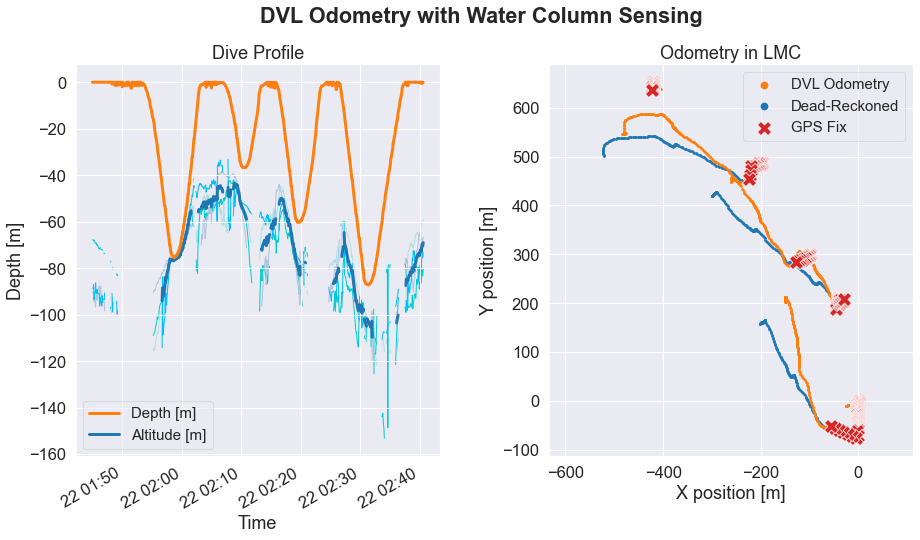

In [1075]:
reload_modules()
# dvl_plotter.plot_profile_and_navigation(ts, ts_flight_kolumbo_all, save_name='tmp-profile.png')
dvl_plotter.plot_profile_and_odometry_and_dr(ts, ts_flight_kolumbo_all, save_name='tmp-profile.png')

---
### B. MF-TAN: Factor Extraction and Seafloor Maps 
*Note: this plot is not displayed in the Jupyter notebook because it is too large to be displayed quickly. Instead, the plot is saved to the specified directory.*


In [1078]:
reload_modules()

# plots bathy maps with three factors extracted 
dvl_plotter.plot_profile_and_odometry_and_dr_and_three_factors(ts, ts_flight_kolumbo_all, bathy_df, save_name='tmp-three-factor.png')

# plots bathy slope map with DVL odometry 
# dvl_plotter.plot_profile_and_odometry_and_dr_and_slope_factor(ts, ts_flight_kolumbo_all, bathy_df, save_name='tmp-slope-factor.png')
print('Plotting Done!')

Plotting Done!


---
### C. Water Column Currents

In [ ]:
reload_modules()
dvl_plotter.plot_water_column_currents(voc_u_list, voc_v_list, voc_w_list, voc_z_list, save_name='tmp-water-column.png')

---
### D. Exploitative Depth Band Selection (EDBS)

In [ ]:
reload_modules()
dive_b_depth = 67
dive_f_depth = 97

dive_depth = dive_b_depth
arctic_depth = 80
heading_list = np.arange(0,45,45)

#################################################
# Rescale Ocean Currents + add Gyre #############
#################################################
strawman_voc_u, strawman_voc_v, strawman_voc_z = AdaptiveVelocityController.AVC.get_rescaled_voc_lists(
    dive_depth, 
    arctic_depth, 
    voc_u_list, 
    voc_v_list
)
# add gyre component to the water column
gyre_mag = 0.1
gyre_dir = 315
gyre_u   = gyre_mag*np.sin(gyre_dir*np.pi/180)
gyre_v   = gyre_mag*np.cos(gyre_dir*np.pi/180)
depth_band_voc_u = list(np.array(strawman_voc_u) + gyre_u)
depth_band_voc_v = list(np.array(strawman_voc_v) + gyre_v)


# #################################################
# # Compute the Optimal Depth Band ################
# #################################################
# for heading in heading_list:
#     P_hotel_survey          = 6.37
#     p_hotel_transit_reduced = 0.37 + 0.2 + 0.2
#     p_hotel_survey_reduced  = 0.37 + 1.75
#     max_depth = 80
#     pitch     = 5
#     p_hotel   = p_hotel_survey_reduced
#     opt_z_dive, opt_z_climb, opt_TC, dive_list, climb_list, TC_list = AdaptiveVelocityController.AVC.get_optimal_depth_band(
#         depth_band_voc_u, 
#         depth_band_voc_v, 
#         max_depth, 
#         heading,
#         pitch, 
#         p_hotel,
#         voc_interval_len=1, 
#         percent_ballast=0.2
#     )


# #################################################
# # Plotting the Optimal Depth Band ###############
# #################################################
#     dvl_plotter.plot_exploitative_depth_bands(
#         dive_list, 
#         climb_list, 
#         TC_list, 
#         heading, 
#         np.array(depth_band_voc_u),
#         np.array(depth_band_voc_v),
#         np.array([0 for _ in depth_band_voc_u]),
#         np.array(strawman_voc_z)
#     )



--- 
<a id='sandbox'></a>
## Sandbox
Code below this cell is experimental and may contain bugs.

In [ ]:
p_default_dvl_msis_bsd   = 2.00 + 3.00 + 0.4 # W
p_reduce_dvl_msis_bsd    = 0.64 + 0.66 + 0.2 # W
p_other_hotel            = 0.97
p_hotel_transit_with_dvl = 0.37 + 2.0  + 0.4 # W
p_hotel_transit_reduced  = 0.37 + 0.64 + 0.2 # W
p_hotel_survey           = 0.37 + 6.0        # W
p_hotel_survey_reduced   = 0.37 + p_other_hotel + p_reduce_dvl_msis_bsd

---
## Glider Range Simulator

In [ ]:
###########################################
# CONSTANTS 
# # these values are from the glider spreadsheet document 
# p_buoyancy_26deg_50m = 11.03   # Whr/km
# p_buoyancy_12deg_50m =  5.75   # Whr/km
# p_buoyancy_12deg_25m =  6.88   # Whr/km

buoyant_26deg_speed  = 0.37    # m/s
buoyant_12deg_speed  = 0.26    # m/s

p_default_dvl_msis_bsd   = 2.00 + 3.00 + 0.4 # W
p_reduce_dvl_msis_bsd    = 0.64 + 0.66 + 0.2 # W
p_other_hotel            = 0.97

p_hotel_transit_with_dvl = 0.37 + 2.0  + 0.4 # W
p_hotel_transit_reduced  = 0.37 + 0.64 + 0.2 # W
p_hotel_survey           = 0.37 + 6.0        # W
p_hotel_survey_reduced   = 0.37 + p_other_hotel + p_reduce_dvl_msis_bsd

# amount of buoyancy engine power (and speed) reduced
buoyancy_reduction       = 0.2  # value deduced after discussing with Rich 


res = 200
v_list = np.linspace(0,1.5,res)
hybrid_constant_speed_transit_vtw = get_opt_v(v_list, 0, 0, p_hotel_transit_with_dvl, energy_supply)
hybrid_constant_speed_science_vtw = get_opt_v(v_list, 0, 0, p_hotel_survey,           energy_supply)
hybrid_constant_speed_transit_pow = get_prop_power(hybrid_constant_speed_transit_vtw)
hybrid_constant_speed_science_pow = get_prop_power(hybrid_constant_speed_science_vtw)



###########################################
# CASE 1: 26 degree engine buoyancy engine 
buoyancy_26_deg_x = [0]
buoyancy_26_deg_y = [0]
buoyancy_26_deg_z = [0]
buoyancy_26_deg_t = [0]
buoyancy_26_deg_e = [0]
buoyancy_26_sci_d = 0
buoyancy_26_sci_t = 0
buoyancy_26_num_i = 0



###########################################
# CASE 2: 12 degree engine buoyancy engine 
buoyancy_12_deg_x = [0]
buoyancy_12_deg_y = [0]
buoyancy_12_deg_z = [0]
buoyancy_12_deg_t = [0]
buoyancy_12_deg_e = [0]
buoyancy_12_sci_d = 0
buoyancy_12_sci_t = 0
buoyancy_12_num_i = 0



###########################################
# CASE 3: constant hybrid speed 
hybrid_constant_x = [0]
hybrid_constant_y = [0]
hybrid_constant_z = [0]
hybrid_constant_t = [0]
hybrid_constant_e = [0]
hybrid_cons_sci_d = 0
hybrid_cons_sci_t = 0
hybrid_cons_num_i = 0



###########################################
# CASE 4: adaptive hybrid speed 
hybrid_adaptive_x = [0]
hybrid_adaptive_y = [0]
hybrid_adaptive_z = [0]
hybrid_adaptive_t = [0]
hybrid_adaptive_e = [0]
hybrid_adap_sci_d = 0
hybrid_adap_sci_t = 0
hybrid_adap_num_i = 0

hybrid_adap_vtw_d = {}
hybrid_adap_sci_vtw_d = {}
for waypoint_index in range(len(waypoints)-1):
    hybrid_adap_vtw_d[waypoint_index] = {}
    glider_heading = get_heading(waypoints[waypoint_index], waypoints[waypoint_index+1])
    for z in range(arctic_depth):
        voc_u = strawman_voc_u[z]
        voc_v = strawman_voc_v[z]
        if np.isnan(voc_u):
            voc_u = 0
            voc_v = 0
        ocean_heading  = np.arctan2(voc_u, voc_v)
        ocean_mag      = np.linalg.norm([voc_u, voc_v])
        delta_heading  = ocean_heading - glider_heading
        vtw            = get_opt_v(v_list, ocean_mag, delta_heading, p_hotel_transit_with_dvl, energy_supply)
        hybrid_adap_vtw_d[waypoint_index][z] = vtw
for i in range(4):
    glider_heading = 0 + i*(np.pi/2)
    hybrid_adap_sci_vtw_d[glider_heading] = {}
    for z in range(arctic_depth):
        gyre_u = 0.1*np.sin(315*np.pi/180)
        gyre_v = 0.1*np.cos(315*np.pi/180)
        
        voc_u = strawman_voc_u[z] + gyre_u
        voc_v = strawman_voc_v[z] + gyre_v
            
        ocean_heading  = np.arctan2(voc_u, voc_v)
        ocean_mag      = np.linalg.norm([voc_u, voc_v])
        delta_heading  = ocean_heading - glider_heading
        vtw_sci        = get_opt_v(v_list, ocean_mag, delta_heading, p_hotel_survey*1, energy_supply)
        hybrid_adap_sci_vtw_d[glider_heading][z] = vtw_sci
        
        

###########################################
# CASE 5: reduced hotel load 
hybrid_reduce_h_x = [0]
hybrid_reduce_h_y = [0]
hybrid_reduce_h_z = [0]
hybrid_reduce_h_t = [0]
hybrid_reduce_h_e = [0]
hybrid_reduce_sci_d = 0
hybrid_reduce_sci_t = 0
hybrid_reduce_num_i = 0

hybrid_reduce_vtw_d = {}
hybrid_reduce_sci_vtw_d = {}
for waypoint_index in range(len(waypoints)-1):
    hybrid_reduce_vtw_d[waypoint_index] = {}
    glider_heading = get_heading(waypoints[waypoint_index], waypoints[waypoint_index+1])
    for z in range(arctic_depth):
        voc_u = strawman_voc_u[z]
        voc_v = strawman_voc_v[z]
        if np.isnan(voc_u):
            voc_u = 0
            voc_v = 0
        ocean_heading  = np.arctan2(voc_u, voc_v)
        ocean_mag      = np.linalg.norm([voc_u, voc_v])
        delta_heading  = ocean_heading - glider_heading
        vtw            = get_opt_v(v_list, ocean_mag, delta_heading, p_hotel_transit_reduced, energy_supply)
        hybrid_reduce_vtw_d[waypoint_index][z] = vtw
for i in range(4):
    glider_heading = 0 + i*(np.pi/2)
    hybrid_reduce_sci_vtw_d[glider_heading] = {}
    for z in range(arctic_depth):
        gyre_u = 0.1*np.sin(315*np.pi/180)
        gyre_v = 0.1*np.cos(315*np.pi/180)
        
        voc_u = strawman_voc_u[z] + gyre_u
        voc_v = strawman_voc_v[z] + gyre_v
        
        ocean_heading  = np.arctan2(voc_u, voc_v)
        ocean_mag      = np.linalg.norm([voc_u, voc_v])
        delta_heading  = ocean_heading - glider_heading
        vtw_sci        = get_opt_v(v_list, ocean_mag, delta_heading, p_hotel_survey_reduced, energy_supply)
        hybrid_reduce_sci_vtw_d[glider_heading][z] = vtw_sci


###########################################
# CASE 6: exploitative depth banding 
# 25m depth banding -- should be twice as expensive compared to others 
hybrid_depthbnd_x = [0]
hybrid_depthbnd_y = [0]
hybrid_depthbnd_z = [0]
hybrid_depthbnd_t = [0]
hybrid_depthbnd_e = [0]

hybrid_depthbnd_sci_d = 0
hybrid_depthbnd_sci_t = 0
hybrid_depthbnd_num_i = 0


compute_cases = {
    1 : True,
    2 : True, 
    3 : True,  
    4 : True, 
    5 : True, 
    6 : True, 
# }

# compute_cases = {
#     1 : False,
# #     1 : True,
#     2 : False,
# #     2 : True,
#     3 : False, 
# #     3 : True, 
#     4 : False, 
# #     4 : True, 
# #     5 : False,
#     5 : True, 
# #     6 : False,
#     6 : True, 
# }


# CASE 1 ##################################
if compute_cases[1]:
    print("> computing case 1")
    waypoint_capture   = 10 # m
    vertical_direction = 1
    for waypoint_index in range(len(waypoints)-1):

        flag_hit_waypoint = False
        curr_position  = (buoyancy_26_deg_x[-1], buoyancy_26_deg_y[-1])
        depth          =  buoyancy_26_deg_z[-1]
        next_waypoint  = waypoints[waypoint_index+1]
        glider_heading = get_heading(curr_position, next_waypoint)

        # iterate until next waypoint is hit 
        for t in range(500000):
            prev_x, prev_y, prev_z = buoyancy_26_deg_x[-1], buoyancy_26_deg_y[-1], buoyancy_26_deg_z[-1]
            ocean_heading  = np.arctan2(avg_voc_u, avg_voc_v)
            delta_heading  = ocean_heading - glider_heading
            
            voc_hor        = buoyant_26deg_speed
            voc_ver        = np.tan(26*np.pi/180)*buoyant_26deg_speed*vertical_direction
            voc_para       = avg_voc_mag*np.cos(delta_heading)
            voc_perp       = avg_voc_mag*np.sin(delta_heading)
            vtw_para       = (voc_hor**2 - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_t        = 10
            delta_dist     = vog_para*delta_t
            delta_x        = delta_dist*np.sin(glider_heading)
            delta_y        = delta_dist*np.cos(glider_heading)
            delta_z        = delta_t*voc_ver
            new_x          = prev_x+delta_x
            new_y          = prev_y+delta_y
            new_z          = prev_z+delta_z 
            delta_e        = (delta_t/3600) * p_hotel_transit_with_dvl
            
            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                vertical_direction *= -1
                buoyancy_26_num_i  +=  1
                buoyancy_26_deg_e.append(2.95)
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1
                
            # updates lists 
            buoyancy_26_deg_x.append(new_x)
            buoyancy_26_deg_y.append(new_y)
            buoyancy_26_deg_z.append(new_z)
            buoyancy_26_deg_t.append(delta_t)
            buoyancy_26_deg_e.append(delta_e)

            # check if glider made it to the waypoint
            if get_distance((new_x,new_y), next_waypoint) < waypoint_capture:
                flag_hit_waypoint = True
                break

        if not flag_hit_waypoint:
            print("  WARNING: missed a waypoint")
        

# CASE 2 ##################################
if compute_cases[2]:
    print("> computing case 2")
    waypoint_capture   = 10 # m
    vertical_direction = 1
    glider_pitch       = 12
    for waypoint_index in range(len(waypoints)-1):

        flag_hit_waypoint = False
        curr_position  = (buoyancy_12_deg_x[-1], buoyancy_12_deg_y[-1])
        next_waypoint  = waypoints[waypoint_index+1]
        glider_heading = get_heading(curr_position, next_waypoint)

        # iterate until next waypoint is hit 
        for t in range(500000):
            prev_x, prev_y, prev_z = buoyancy_12_deg_x[-1], buoyancy_12_deg_y[-1], buoyancy_12_deg_z[-1]
            ocean_heading  = np.arctan2(avg_voc_u, avg_voc_v)
            delta_heading  = ocean_heading - glider_heading
            
            voc_hor        = buoyant_12deg_speed
            voc_ver        = np.tan(12*np.pi/180)*buoyant_12deg_speed*vertical_direction
            voc_para       = avg_voc_mag*np.cos(delta_heading)
            voc_perp       = avg_voc_mag*np.sin(delta_heading)
            vtw_para       = (voc_hor**2 - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_t        = 10
            delta_dist     = vog_para*delta_t
            delta_x        = delta_dist*np.sin(glider_heading)
            delta_y        = delta_dist*np.cos(glider_heading)
            delta_z        = delta_t*voc_ver
            new_x          = prev_x+delta_x
            new_y          = prev_y+delta_y
            new_z          = prev_z+delta_z

            # convert total power in W to Whrs
            delta_e        = (delta_t/3600) * p_hotel_transit_with_dvl 
            
            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                vertical_direction *= -1
                buoyancy_12_num_i  +=  1
                buoyancy_12_deg_e.append(2.95)
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1
                
            # updates lists 
            buoyancy_12_deg_x.append(new_x)
            buoyancy_12_deg_y.append(new_y)
            buoyancy_12_deg_z.append(new_z)
            buoyancy_12_deg_t.append(delta_t)
            buoyancy_12_deg_e.append(delta_e)

            # check if glider made it to the waypoint
            if get_distance((new_x,new_y), next_waypoint) < waypoint_capture:
                flag_hit_waypoint = True
                break

        if not flag_hit_waypoint:
            print("  WARNING: missed a waypoint")
            
    # perform science
    science_energy = energy_supply - sum(buoyancy_12_deg_e)
    glider_heading = 0
    new_z = 0
    vertical_direction = 1
    print("  computing science statistics")
    while science_energy > 0:
        glider_heading += np.pi/2
        glider_heading  = glider_heading % (2*np.pi)
        
        for _ in range(160):
            prev_z   = new_z
            gyre_u   = 0.1*np.sin(315*np.pi/180)
            gyre_v   = 0.1*np.cos(315*np.pi/180)

            ocean_heading  = np.arctan2(avg_voc_u+gyre_u, avg_voc_v+gyre_v)
            ocean_mag      = np.linalg.norm([avg_voc_u+gyre_u, avg_voc_v+gyre_v])
            delta_heading  = ocean_heading - glider_heading 

            vtw_hor        = buoyant_12deg_speed
            vtw_ver        = buoyant_12deg_speed*np.tan(12*np.pi/180)*vertical_direction

            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_dist     = 10
            delta_t        = delta_dist/vog_para
            p_total        = p_hotel_survey
            delta_e        = (delta_t/3600) * p_total

            delta_z        = delta_t*vtw_ver
            new_z          = prev_z+delta_z

            buoyancy_12_sci_d +=  delta_dist
            buoyancy_12_sci_t +=  delta_t
            science_energy    += -delta_e

            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                vertical_direction  *= -1
                buoyancy_12_num_i   +=  1
                science_energy      += -2.95
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1
            
        
        
# CASE 3 ##################################
if compute_cases[3]:
    print("> computing case 3")
    waypoint_capture   = 10 # m
    vertical_direction = 1
    glider_pitch       = 12
    for waypoint_index in range(len(waypoints)-1):

        flag_hit_waypoint = False
        curr_position  = (hybrid_constant_x[-1], hybrid_constant_y[-1])
        curr_depth     =  hybrid_constant_z[-1]
        next_waypoint  = waypoints[waypoint_index+1]
        glider_heading = get_heading(curr_position, next_waypoint)

        # iterate until next waypoint is hit 
        for t in range(200000):
            prev_x, prev_y, prev_z = hybrid_constant_x[-1], hybrid_constant_y[-1], hybrid_constant_z[-1]
            voc_u = strawman_voc_u[int(prev_z)]
            voc_v = strawman_voc_v[int(prev_z)]
            if np.isnan(voc_u):
                voc_u = 0
                voc_v = 0
            ocean_heading  = np.arctan2(voc_u, voc_v)
            ocean_mag      = np.linalg.norm([voc_u, voc_v])
            delta_heading  = ocean_heading - glider_heading

            vtw            = hybrid_constant_speed_transit_vtw    
            vtw_hor        = vtw*np.cos(12*np.pi/180)
            vtw_ver        = vtw*np.sin(12*np.pi/180)*vertical_direction            
            
            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_t        = 10
            delta_dist     = vog_para*delta_t
            delta_x        = delta_dist*np.sin(glider_heading)
            delta_y        = delta_dist*np.cos(glider_heading)
            delta_z        = delta_t*vtw_ver
            new_x          = prev_x+delta_x
            new_y          = prev_y+delta_y
            new_z          = prev_z+delta_z

            # convert total power in W to Whrs
            p_total        = p_hotel_transit_with_dvl + hybrid_constant_speed_transit_pow
            delta_e        = (delta_t/3600) * p_total
            
            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                vertical_direction *= -1
                hybrid_cons_num_i  +=  1
                hybrid_constant_e.append(2.95)
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1

            # updates lists 
            hybrid_constant_x.append(new_x)
            hybrid_constant_y.append(new_y)
            hybrid_constant_z.append(new_z)
            hybrid_constant_t.append(delta_t)
            hybrid_constant_e.append(delta_e)

            # check if glider made it to the waypoint
            if get_distance((new_x,new_y), next_waypoint) < waypoint_capture:
                flag_hit_waypoint = True
                break

        if not flag_hit_waypoint:
            print("  WARNING: missed a waypoint")
            
    # perform science
    science_energy = energy_supply - sum(hybrid_constant_e)
    glider_heading = 0
    new_z = 0
    vertical_direction = 1
    print("  computing science statistics")
    while science_energy > 0:
        glider_heading += np.pi/2
        glider_heading  = glider_heading % (2*np.pi)
        
        for _ in range(160):
            prev_z   = new_z
            gyre_u   = 0.1*np.sin(315*np.pi/180)
            gyre_v   = 0.1*np.cos(315*np.pi/180)
            voc_u    = strawman_voc_u[int(prev_z)] + gyre_u
            voc_v    = strawman_voc_v[int(prev_z)] + gyre_v

            ocean_heading  = np.arctan2(voc_u, voc_v)
            ocean_mag      = np.linalg.norm([voc_u, voc_v])
            delta_heading  = ocean_heading - glider_heading

            vtw            = hybrid_constant_speed_science_vtw    
            vtw_hor        = vtw*np.cos(12*np.pi/180)
            vtw_ver        = vtw*np.sin(12*np.pi/180)*vertical_direction

            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_dist     = 10
            delta_t        = delta_dist/vog_para
            p_total        = p_hotel_survey + get_prop_power(vtw)
            delta_e        = (delta_t/3600) * p_total

            delta_z        = delta_t*vtw_ver
            new_z          = prev_z+delta_z

            hybrid_cons_sci_d +=  delta_dist
            hybrid_cons_sci_t +=  delta_t
            science_energy    += -delta_e

            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                vertical_direction  *= -1
                hybrid_cons_num_i   +=  1
                science_energy      += -2.95
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1

            
# CASE 4 ##################################
if compute_cases[4]:
    print("> computing case 4")
    waypoint_capture   = 10 # m
    vertical_direction = 1
    glider_pitch       = 12
    for waypoint_index in range(len(waypoints)-1):

        flag_hit_waypoint = False
        curr_position  = (hybrid_adaptive_x[-1], hybrid_adaptive_y[-1])
        curr_depth     =  hybrid_adaptive_z[-1]
        next_waypoint  = waypoints[waypoint_index+1]
        glider_heading = get_heading(curr_position, next_waypoint)

        # iterate until next waypoint is hit 
        for t in range(200000):
            prev_x, prev_y, prev_z = hybrid_adaptive_x[-1], hybrid_adaptive_y[-1], hybrid_adaptive_z[-1]
            voc_u = strawman_voc_u[int(prev_z)]
            voc_v = strawman_voc_v[int(prev_z)]
            if np.isnan(voc_u):
                voc_u = 0
                voc_v = 0
            ocean_heading  = np.arctan2(voc_u, voc_v)
            ocean_mag      = np.linalg.norm([voc_u, voc_v])
            delta_heading  = ocean_heading - glider_heading
            
            vtw            = hybrid_adap_vtw_d[waypoint_index][int(prev_z)]
            
            vtw_hor        = vtw*np.cos(12*np.pi/180)
            vtw_ver        = vtw*np.sin(12*np.pi/180)*vertical_direction

            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_t        = 10
            delta_dist     = vog_para*delta_t
            delta_x        = delta_dist*np.sin(glider_heading)
            delta_y        = delta_dist*np.cos(glider_heading)
            delta_z        = delta_t*vtw_ver
            new_x          = prev_x+delta_x
            new_y          = prev_y+delta_y
            new_z          = prev_z+delta_z

            # convert total power in W to Whrs
            p_total        = p_hotel_transit_with_dvl + get_prop_power(vtw)
            delta_e        = (delta_t/3600) * p_total
            
            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                hybrid_adaptive_e.append(2.95)
                hybrid_adap_num_i  +=  1
                vertical_direction *= -1
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1

            # updates lists 
            hybrid_adaptive_x.append(new_x)
            hybrid_adaptive_y.append(new_y)
            hybrid_adaptive_z.append(new_z)
            hybrid_adaptive_t.append(delta_t)
            hybrid_adaptive_e.append(delta_e)

            # check if glider made it to the waypoint
            if get_distance((new_x,new_y), next_waypoint) < waypoint_capture:
                flag_hit_waypoint = True
                break

        if not flag_hit_waypoint:
            print("  WARNING: missed a waypoint")
            
    # perform science
    science_energy = energy_supply - sum(hybrid_adaptive_e)
    glider_heading = 0
    new_z = 0
    vertical_direction = 1
    print("  computing science statistics")
    while science_energy > 0:
        glider_heading += np.pi/2
        glider_heading  = glider_heading % (2*np.pi)
        
        for _ in range(160):
            prev_z   = new_z
            gyre_u   = 0.1*np.sin(315*np.pi/180)
            gyre_v   = 0.1*np.cos(315*np.pi/180)
            voc_u    = strawman_voc_u[int(prev_z)] + gyre_u
            voc_v    = strawman_voc_v[int(prev_z)] + gyre_v

            ocean_heading  = np.arctan2(voc_u, voc_v)
            ocean_mag      = np.linalg.norm([voc_u, voc_v])
            delta_heading  = ocean_heading - glider_heading

            vtw            = hybrid_adap_sci_vtw_d[glider_heading][int(prev_z)]

            vtw_hor        = vtw*np.cos(12*np.pi/180)
            vtw_ver        = vtw*np.sin(12*np.pi/180)*vertical_direction

            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_dist     = 10
            delta_t        = delta_dist/vog_para
            p_total        = p_hotel_survey + get_prop_power(vtw)
            delta_e        = (delta_t/3600) * p_total

            delta_z        = delta_t*vtw_ver
            new_z          = prev_z+delta_z

            hybrid_adap_sci_d +=  delta_dist
            hybrid_adap_sci_t +=  delta_t
            science_energy    += -delta_e

            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                vertical_direction  *= -1
                hybrid_adap_num_i   +=  1
                science_energy      += -2.95
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1

            
# CASE 5 ##################################
if compute_cases[5]:
    print("> computing case 5")
    waypoint_capture   = 10 # m
    vertical_direction = 1
    glider_pitch       = 5
    for waypoint_index in range(len(waypoints)-1):

        flag_hit_waypoint = False
        curr_position  = (hybrid_reduce_h_x[-1], hybrid_reduce_h_y[-1])
        curr_depth     =  hybrid_reduce_h_z[-1]
        next_waypoint  = waypoints[waypoint_index+1]
        glider_heading = get_heading(curr_position, next_waypoint)

        # iterate until next waypoint is hit 
        for t in range(200000):
            prev_x, prev_y, prev_z = hybrid_reduce_h_x[-1], hybrid_reduce_h_y[-1], hybrid_reduce_h_z[-1]
            voc_u = strawman_voc_u[int(prev_z)]
            voc_v = strawman_voc_v[int(prev_z)]
            if np.isnan(voc_u):
                voc_u = 0
                voc_v = 0
            ocean_heading  = np.arctan2(voc_u, voc_v)
            ocean_mag      = np.linalg.norm([voc_u, voc_v])
            delta_heading  = ocean_heading - glider_heading
            
            vtw            = hybrid_reduce_vtw_d[waypoint_index][int(prev_z)]
            
            vtw_hor        = vtw*np.cos(glider_pitch*np.pi/180)
            vtw_ver        = vtw*np.sin(glider_pitch*np.pi/180)*vertical_direction

            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_t        = 10
            delta_dist     = vog_para*delta_t
            delta_x        = delta_dist*np.sin(glider_heading)
            delta_y        = delta_dist*np.cos(glider_heading)
            delta_z        = delta_t*vtw_ver
            new_x          = prev_x+delta_x
            new_y          = prev_y+delta_y
            new_z          = prev_z+delta_z

            # convert total power in W to Whrs
            # TODO
            p_total        = p_hotel_transit_reduced + get_prop_power(vtw)
            delta_e        = (delta_t/3600) * p_total
            
            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                hybrid_reduce_h_e.append(2.95*buoyancy_reduction)
                hybrid_reduce_num_i +=  1
                vertical_direction  *= -1
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1

            # updates lists 
            hybrid_reduce_h_x.append(new_x)
            hybrid_reduce_h_y.append(new_y)
            hybrid_reduce_h_z.append(new_z)
            hybrid_reduce_h_t.append(delta_t)
            hybrid_reduce_h_e.append(delta_e)

            # check if glider made it to the waypoint
            if get_distance((new_x,new_y), next_waypoint) < waypoint_capture:
                flag_hit_waypoint = True
                break

        if not flag_hit_waypoint:
            print("  WARNING: missed a waypoint")
    
    # perform science
    science_energy = energy_supply - sum(hybrid_reduce_h_e)
    glider_heading = 0
    new_z = 0
    vertical_direction = 1
    print("  computing science statistics")
    while science_energy > 0:
        glider_heading += np.pi/2
        glider_heading  = glider_heading % (2*np.pi)
        
        for _ in range(160):
            prev_z   = new_z
            gyre_u   = 0.1*np.sin(315*np.pi/180)
            gyre_v   = 0.1*np.cos(315*np.pi/180)
            voc_u    = strawman_voc_u[int(prev_z)] + gyre_u
            voc_v    = strawman_voc_v[int(prev_z)] + gyre_v

            ocean_heading  = np.arctan2(voc_u, voc_v)
            ocean_mag      = np.linalg.norm([voc_u, voc_v])
            delta_heading  = ocean_heading - glider_heading

            vtw            = hybrid_reduce_sci_vtw_d[glider_heading][int(prev_z)]

            vtw_hor        = vtw*np.cos(glider_pitch*np.pi/180)
            vtw_ver        = vtw*np.sin(glider_pitch*np.pi/180)*vertical_direction

            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_dist     = 10
            delta_t        = delta_dist/vog_para
            p_total        = p_hotel_survey_reduced + get_prop_power(vtw)
            delta_e        = (delta_t/3600) * p_total

            delta_z        = delta_t*vtw_ver
            new_z          = prev_z+delta_z

            hybrid_reduce_sci_d +=  delta_dist
            hybrid_reduce_sci_t +=  delta_t
            science_energy      += -delta_e

            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                vertical_direction  *= -1
                hybrid_reduce_num_i +=  1
                science_energy      += -2.95*buoyancy_reduction
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1
            
            
# CASE 6 ##################################
if compute_cases[6]:
    print("> computing case 6")
    waypoint_capture   = 10 # m
    vertical_direction = 1
    glider_pitch       = 5
    for waypoint_index in range(len(waypoints)-1):

        flag_hit_waypoint = False
        curr_position    = (hybrid_depthbnd_x[-1], hybrid_depthbnd_y[-1])
        curr_depth       =  hybrid_depthbnd_z[-1]
        next_waypoint    = waypoints[waypoint_index+1]
        glider_heading   = get_heading(curr_position, next_waypoint)
        waypoint_heading = get_heading(waypoints[waypoint_index], waypoints[waypoint_index+1])
        
        # result of optimal depth band algorithm 
        epsilon     = 0.0001
        z_climb     = 0
        z_dive      = len(strawman_voc_u)-1
        if   abs(waypoint_heading - (-0.06334)) < epsilon:
            z_climb = 39
            z_dive  = 79
        elif abs(waypoint_heading - (-0.16272)) < epsilon:
            z_climb = 43
            z_dive  = 79
        elif abs(waypoint_heading - ( 2.97886)) < epsilon:
            z_climb = 0
            z_dive  = 50
        elif abs(waypoint_heading - ( 3.07825)) < epsilon:
            z_climb = 0
            z_dive  = 61
        # 0 -0.06334   transit: (39,79)  survey: (43,79)
        # 1 -0.16272   transit: (43,79)  survey: (45,79)
        # 2  2.97886   transit: (0,50)   survey: (0, 45)
        # 3  3.07825   transit: (0,61)   survey: (0, 48)

        # iterate until next waypoint is hit 
        for t in range(200000):
            prev_x, prev_y, prev_z = hybrid_depthbnd_x[-1], hybrid_depthbnd_y[-1], hybrid_depthbnd_z[-1]
            voc_u = strawman_voc_u[int(prev_z)]
            voc_v = strawman_voc_v[int(prev_z)]
            if np.isnan(voc_u):
                voc_u = 0
                voc_v = 0
            ocean_heading  = np.arctan2(voc_u, voc_v)
            ocean_mag      = np.linalg.norm([voc_u, voc_v])
            delta_heading  = ocean_heading - glider_heading
            
            vtw            = hybrid_reduce_vtw_d[waypoint_index][int(prev_z)]
            
            vtw_hor        = vtw*np.cos(glider_pitch*np.pi/180)
            vtw_ver        = vtw*np.sin(glider_pitch*np.pi/180)*vertical_direction

            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_t        = 10
            delta_dist     = vog_para*delta_t
            delta_x        = delta_dist*np.sin(glider_heading)
            delta_y        = delta_dist*np.cos(glider_heading)
            delta_z        = delta_t*vtw_ver
            new_x          = prev_x+delta_x
            new_y          = prev_y+delta_y
            new_z          = prev_z+delta_z

            # convert total power in W to Whrs
            # TODO
            p_total        = p_hotel_transit_reduced + get_prop_power(vtw)
            delta_e        = (delta_t/3600) * p_total
            

            half_depth    = int(arctic_depth/2)
            overlap       = 10
            if new_z > z_dive:
                new_z = z_dive
                hybrid_depthbnd_e.append(2.95*buoyancy_reduction)
                hybrid_depthbnd_num_i +=  1
                vertical_direction    *= -1
            elif new_z < z_climb:
                new_z = z_climb
                vertical_direction *= -1

            # updates lists 
            hybrid_depthbnd_x.append(new_x)
            hybrid_depthbnd_y.append(new_y)
            hybrid_depthbnd_z.append(new_z)
            hybrid_depthbnd_t.append(delta_t)
            hybrid_depthbnd_e.append(delta_e)

            # check if glider made it to the waypoint
            if get_distance((new_x,new_y), next_waypoint) < waypoint_capture:
                flag_hit_waypoint = True
                break

        if not flag_hit_waypoint:
            print("  WARNING: missed a waypoint")
    
    # perform science
    science_energy = energy_supply - sum(hybrid_depthbnd_e)
    glider_heading = 0
    new_z = 0
    vertical_direction = 1
    print("  computing science statistics")
    while science_energy > 0:
        glider_heading += np.pi/2
        glider_heading  = glider_heading % (2*np.pi)
        
        z_dive  = len(strawman_voc_u) - 1
        z_climb = 0
        epsilon = 0.0001
        if   abs(glider_heading - 0.00000) < epsilon:
            z_climb = 39
            z_dive  = 79
        elif abs(glider_heading - 1.57079) < epsilon:
            z_climb = 0 
            z_dive  = 52
        elif abs(glider_heading - 3.14159) < epsilon:
            z_climb = 0
            z_dive  = 48
        elif abs(glider_heading - 4.71238) < epsilon:
            z_climb = 37
            z_dive  = 79
        
        for _ in range(160):
            prev_z   = new_z
            gyre_u   = 0.1*np.sin(315*np.pi/180)
            gyre_v   = 0.1*np.cos(315*np.pi/180)
            voc_u    = strawman_voc_u[int(prev_z)] + gyre_u
            voc_v    = strawman_voc_v[int(prev_z)] + gyre_v

            ocean_heading  = np.arctan2(voc_u, voc_v)
            ocean_mag      = np.linalg.norm([voc_u, voc_v])
            delta_heading  = ocean_heading - glider_heading

            vtw            = hybrid_reduce_sci_vtw_d[glider_heading][int(prev_z)]

            vtw_hor        = vtw*np.cos(glider_pitch*np.pi/180)
            vtw_ver        = vtw*np.sin(glider_pitch*np.pi/180)*vertical_direction

            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_dist     = 10
            delta_t        = delta_dist/vog_para
            p_total        = p_hotel_survey_reduced + get_prop_power(vtw)
            delta_e        = (delta_t/3600) * p_total

            delta_z        = delta_t*vtw_ver
            new_z          = prev_z+delta_z

            hybrid_depthbnd_sci_d +=  delta_dist
            hybrid_depthbnd_sci_t +=  delta_t
            science_energy        += -delta_e

            if new_z > z_dive:
                new_z = z_dive
                vertical_direction    *= -1
                hybrid_depthbnd_num_i +=  1
                science_energy        += -2.95*buoyancy_reduction
            elif new_z < z_climb:
                new_z = z_climb
                vertical_direction *= -1
            


distance_traveled_26 = \
    sum([get_distance((buoyancy_26_deg_x[i],  buoyancy_26_deg_y[i]), 
                      (buoyancy_26_deg_x[i+1],buoyancy_26_deg_y[i+1]))
        for i in range(len(buoyancy_26_deg_x)-1)])

distance_traveled_12 = \
    sum([get_distance((buoyancy_12_deg_x[i],  buoyancy_12_deg_y[i]), 
                      (buoyancy_12_deg_x[i+1],buoyancy_12_deg_y[i+1]))
        for i in range(len(buoyancy_12_deg_x)-1)])

distance_traveled_constant_thrust = \
    sum([get_distance((hybrid_constant_x[i],  hybrid_constant_y[i]), 
                      (hybrid_constant_x[i+1],hybrid_constant_y[i+1]))
        for i in range(len(hybrid_constant_x)-1)])

distance_traveled_adaptive_thrust = \
    sum([get_distance((hybrid_adaptive_x[i],  hybrid_adaptive_y[i]), 
                      (hybrid_adaptive_x[i+1],hybrid_adaptive_y[i+1]))
        for i in range(len(hybrid_adaptive_x)-1)])

distance_traveled_reduced_hotel = \
    sum([get_distance((hybrid_reduce_h_x[i],  hybrid_reduce_h_y[i]), 
                      (hybrid_reduce_h_x[i+1],hybrid_reduce_h_y[i+1]))
        for i in range(len(hybrid_reduce_h_x)-1)])

distance_traveled_depth_band = \
    sum([get_distance((hybrid_depthbnd_x[i],  hybrid_depthbnd_y[i]), 
                      (hybrid_depthbnd_x[i+1],hybrid_depthbnd_y[i+1]))
        for i in range(len(hybrid_depthbnd_x)-1)])

print()
if compute_cases[1]:
    print('- 1. Buoyancy Driven at 26 deg ------------------------')
    print('      transit dist: %f [km]'   % (distance_traveled_26/1000))
    print('      transit time: %f [day]'  % (sum(buoyancy_26_deg_t)/60/60/24))
    print('      transit ener: %f [kWhr]' % (sum(buoyancy_26_deg_e)/1000))
    print('      transit econ: %f [J/m]'  % (sum(buoyancy_26_deg_e)*3600/strawman_range))
    print('      science dist: %f [km]'   % (buoyancy_26_sci_d/1000))
    print('      science time: %f [day]'  % (buoyancy_26_sci_t/60/60/24))
    print('      # inflection: %d'        % (buoyancy_26_num_i))
    print('       improvement: %f'        % (0))
    print()

if compute_cases[2]:
    print('- 2. Buoyancy Driven at 12 deg ------------------------')
    print('      transit dist: %f [km]'   % (distance_traveled_12/1000))
    print('      transit time: %f [day]'  % (sum(buoyancy_12_deg_t)/60/60/24))
    print('      transit ener: %f [kWhr]' % (sum(buoyancy_12_deg_e)/1000))
    print('      transit econ: %f [J/m]'  % (sum(buoyancy_12_deg_e)*3600/strawman_range))
    print('      science dist: %f [km]'   % (buoyancy_12_sci_d/1000))
    print('      science time: %f [day]'  % (buoyancy_12_sci_t/60/60/24))
    print('      # inflection: %d'        % (buoyancy_12_num_i))
    print('       improvement: %f'        % ((buoyancy_12_sci_d+strawman_range-baseline_range)/baseline_range*100))
    print()
    
if compute_cases[3]:
    print('- 3. Hybrid Constant Speed ----------------------------')
    print('      transit dist: %f [km]'   % (distance_traveled_constant_thrust/1000) )
    print('      transit time: %f [day]'  % (sum(hybrid_constant_t)/60/60/24))
    print('      transit ener: %f [kWhr]' % (sum(hybrid_constant_e)/1000))
    print('      transit econ: %f [J/m]'  % (sum(hybrid_constant_e)*3600/strawman_range))
    print('      science dist: %f [km]'   % (hybrid_cons_sci_d/1000))
    print('      science time: %f [day]'  % (hybrid_cons_sci_t/60/60/24))
    print('      # inflection: %d'        % (hybrid_cons_num_i))
    print('       improvement: %f'        % ((hybrid_cons_sci_d+strawman_range-baseline_range)/baseline_range*100))
    print()
    
if compute_cases[4]:
    print('- 4. Hybrid Adaptive Speed ----------------------------')
    print('      transit dist: %f [km]'   % (distance_traveled_adaptive_thrust/1000) )
    print('      transit time: %f [day]'  % (sum(hybrid_adaptive_t)/60/60/24))
    print('      transit ener: %f [kWhr]' % (sum(hybrid_adaptive_e)/1000))
    print('      transit econ: %f [J/m]'  % (sum(hybrid_adaptive_e)*3600/strawman_range))
    print('      science dist: %f [km]'   % (hybrid_adap_sci_d/1000))
    print('      science time: %f [day]'  % (hybrid_adap_sci_t/60/60/24))
    print('      # inflection: %d'        % (hybrid_adap_num_i))
    print('       improvement: %f'        % ((hybrid_adap_sci_d+strawman_range-baseline_range)/baseline_range*100))
    print()
    
if compute_cases[5]:
    print('- 5. Reduced Hotel Load -------------------------------')
    print('      transit dist: %f [km]'   % (distance_traveled_reduced_hotel/1000) )
    print('      transit time: %f [day]'  % (sum(hybrid_reduce_h_t)/60/60/24))
    print('      transit ener: %f [kWhr]' % (sum(hybrid_reduce_h_e)/1000))
    print('      transit econ: %f [J/m]'  % (sum(hybrid_reduce_h_e)*3600/strawman_range))
    print('      science dist: %f [km]'   % (hybrid_reduce_sci_d/1000))
    print('      science time: %f [day]'  % (hybrid_reduce_sci_t/60/60/24))
    print('      # inflection: %d'        % (hybrid_reduce_num_i))
    print('       improvement: %f'        % ((hybrid_reduce_sci_d+strawman_range-baseline_range)/baseline_range*100))
    print()
    

if compute_cases[6]:
    print('- 6. Exploitative Depth Banding -----------------------')
    print('      transit dist: %f [km]'   % (distance_traveled_depth_band/1000) )
    print('      transit time: %f [day]'  % (sum(hybrid_depthbnd_t)/60/60/24))
    print('      transit ener: %f [kWhr]' % (sum(hybrid_depthbnd_e)/1000))
    print('      transit econ: %f [J/m]'  % (sum(hybrid_depthbnd_e)*3600/strawman_range))
    print('      science dist: %f [km]'   % (hybrid_depthbnd_sci_d/1000))
    print('      science time: %f [day]'  % (hybrid_depthbnd_sci_t/60/60/24))
    print('      # inflection: %d'        % (hybrid_depthbnd_num_i))
    print('       improvement: %f'        % ((hybrid_depthbnd_sci_d+strawman_range-baseline_range)/baseline_range*100))
    print()

---
## Combine DVL data with Flight Controller and convert to UTM

In [ ]:
reload_modules()
SAVE = False
PLOT = True
glider      = "sentinel"
directory   = "/Users/zduguid/Dropbox (MIT)/MIT-WHOI/Kolumbo cruise 2019/zduguid/pd0-parsed/%s/" % glider
file_list   = [f for f in listdir(directory) if 
               isfile(join(directory,f)) and f.split('.')[-1] == 'CSV' and 
               len(f.split('_odometry')) != 2]

def get_utm_coords_from_glider_lat_lon(m_lat, m_lon): 
    """TODO
    """
    SECS_IN_MIN = 60
    MIN_OFFSET = 100
    lat_min  = m_lat % MIN_OFFSET 
    lon_min  = m_lon % MIN_OFFSET 
    lat_dec  = (m_lat - lat_min)/MIN_OFFSET + lat_min/SECS_IN_MIN
    lon_dec  = (m_lon - lon_min)/MIN_OFFSET + lon_min/SECS_IN_MIN
    utm_pos  = utm.from_latlon(lat_dec, lon_dec)
    easting  = round(utm_pos[0],2)
    northing = round(utm_pos[1],2)
    zone     = utm_pos[2]
    return(easting, northing, zone)

def get_utm_coords_from_bathy_lat_lon(lat, lon): 
    """TODO
    """
    utm_pos  = utm.from_latlon(lat, lon)
    easting  = round(utm_pos[0],2)
    northing = round(utm_pos[1],2)
    zone     = utm_pos[2]
    return(easting, northing, zone)


# build dataframes for each odometry category 
dr_list  = []
odo_list = []
gps_list = []
wpt_list = []
all_list = []

# iterate through each dbd file and 
for f in file_list:
    SECS_IN_HOUR = 60*60
    SECS_IN_MIN  = 60
    df_pd0 = pd.read_csv(directory+f, header=0, index_col=0, parse_dates=True)
    start  = datetime.datetime.fromtimestamp(df_pd0.time[0])
    end    = datetime.datetime.fromtimestamp(df_pd0.time[-1])
    dur    = end - start 
    
    # sub-select a portion of glider flight computer variables
    df_dbd = ts_flight_kolumbo_all.df[str(start):str(end)].copy()
    print(f, "-------------------------")
    
    # extract first lat/lon gps position to use as origin
    for lat in df_dbd.m_gps_lat:
        if not np.isnan(lat):
            origin_m_lat = lat
            break
    origin_index = list(df_dbd.m_gps_lat).index(origin_m_lat)
    origin_m_lon = df_dbd.m_gps_lon[origin_index]
    origin_time  = datetime.datetime.fromtimestamp(df_dbd.time[origin_index])
    origin_hash  = df_dbd.m_filename_hash[origin_index]

    # convert to lat/lon coordinates to decimal fromat 
    origin_east,origin_north,origin_zone = get_utm_coords(origin_m_lat,origin_m_lon)
    
    # account for case when multiple dbd files span a single pd0 file
    print("    # dbd ensembles:  %d" % len(df_dbd))
    print("        # dbd files:  %d" % len(set(df_dbd.m_filename_hash)))
    print("         # missions:  %d" % len(set(df_dbd.m_mission_hash)))
    print("   input <lat, lon>: <%.2f, %.2f>" % (origin_m_lat, origin_m_lon))
    print("     UTM <  E,   N>: <%.2f, %.2f, zone=%d>\n\n" % (origin_east, origin_north, origin_zone))
    
    # extract positional offsets for the same moment in time
    sg2_x_offset = df_dbd[origin_time:].m_x_lmc[0]
    sg2_y_offset = df_dbd[origin_time:].m_y_lmc[0]
    dvl_x_offset = df_pd0[origin_time:].rel_pos_x[0]
    dvl_y_offset = df_pd0[origin_time:].rel_pos_y[0]

    # account for offsets in Glider and DVL file
    # TODO make this more SFB
    utm_dr_x  = df_dbd.m_x_lmc     - sg2_x_offset + origin_east
    utm_dr_y  = df_dbd.m_y_lmc     - sg2_y_offset + origin_north
    utm_dr_z  = df_dbd.m_depth 
    utm_gps_x = df_dbd.m_gps_x_lmc - sg2_x_offset + origin_east
    utm_gps_y = df_dbd.m_gps_y_lmc - sg2_y_offset + origin_north
    utm_wpt_x = df_dbd.c_wpt_x_lmc - sg2_x_offset + origin_east 
    utm_wpt_y = df_dbd.c_wpt_y_lmc - sg2_y_offset + origin_north 
    utm_odo_x = df_pd0.rel_pos_x   - dvl_x_offset + origin_east
    utm_odo_y = df_pd0.rel_pos_y   - dvl_y_offset + origin_north 
    utm_odo_z = df_pd0.rel_pos_z

    # collect data into indvidual DataFrames
    df_seg_dr = pd.DataFrame({
        'utm_dr_x' : utm_dr_x,
        'utm_dr_y' : utm_dr_y,
        'utm_dr_z' : utm_dr_z,
    })
    df_seg_gps = pd.DataFrame({
        'utm_gps_x' : utm_gps_x,
        'utm_gps_y' : utm_gps_y,
    })
    df_seg_odo = pd.DataFrame({
        'utm_odo_x' : utm_odo_x,
        'utm_odo_y' : utm_odo_y,
        'utm_odo_z' : utm_odo_z,
    })
    df_seg_wpt = pd.DataFrame({
        'utm_wpt_x' : utm_wpt_x,
        'utm_wpt_y' : utm_wpt_y,
    })
    
    # add dataframes to running list 
    dr_list.append(df_seg_dr)
    odo_list.append(df_seg_odo)
    gps_list.append(df_seg_gps)
    wpt_list.append(df_seg_wpt)

    # convert data to pandas DataFrame
    frames = {
        'utm_dr_x'  : utm_dr_x,
        'utm_dr_y'  : utm_dr_y,
        'utm_dr_z'  : utm_dr_z,
        'utm_gps_x' : utm_gps_x,
        'utm_gps_y' : utm_gps_y,
        'utm_wpt_x' : utm_wpt_x,
        'utm_wpt_y' : utm_wpt_y,
        'utm_odo_x' : utm_odo_x,
        'utm_odo_y' : utm_odo_y,
        'utm_odo_z' : utm_odo_z,    
    }
    df_all = pd.DataFrame(frames)
    all_list.append(df_all)
    
    # generate plots
    if PLOT:
        dvl_plotter.plot_odometry_and_dr_utm(df_all, glider, '/Users/zduguid/Desktop/fig/%s.png' % f.split('.')[0])
    if SAVE:
        df_odo.to_csv('/Users/zduguid/Desktop/fig/%s.csv' % f.split('.')[0])

In [ ]:
# # COMBINE FILES 
# df_dr_all  = pd.concat(dr_list)
# df_odo_all = pd.concat(odo_list)
# df_gps_all = pd.concat(gps_list)
# df_wpt_all = pd.concat(wpt_list)
# df_all_all = pd.concat(all_list)

# # PLOTTING
# sns.scatterplot(df_dr_all.utm_dr_x, df_dr_all.utm_dr_y)
# sns.scatterplot(df_wpt_all.utm_wpt_x, df_wpt_all.utm_wpt_y)
# sns.scatterplot(df_gps_all.utm_gps_x, df_gps_all.utm_gps_y)
# sns.scatterplot(df_odo_all.utm_odo_x, df_odo_all.utm_odo_y)

# # SAVING
# df_dr_all.to_csv('/Users/zduguid/Downloads/dr_all.csv')
# df_odo_all.to_csv('/Users/zduguid/Downloads/df_odo_all.csv')
# df_gps_all.to_csv('/Users/zduguid/Downloads/df_gps_all.csv')
# df_wpt_all.to_csv('/Users/zduguid/Downloads/df_wpt_all.csv')
# df_all_all.to_csv('/Users/zduguid/Downloads/all_fields_all_dives.csv')

---
<a id='unit-testing'></a>
## Unit Testing

### Velocity Shear Propagation

In [ ]:
%run -i '~/Documents/Arctic-NNA/software/dvl-nav/test_VSP.py'